# Primer parte!

# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

# Load Data

In [208]:
# Cargar datos desde un archivo txt a un dataframe
df = pd.read_csv("/Users/albaruiz/Downloads/Sexto semestre/Análisis numérico para la optimización no-lineal/data/COLL_TEC_CONSOLIDADO.txt", delimiter=",", encoding="latin-1", low_memory=False)

# Hacer dataframe
df = pd.DataFrame(df)
df.head()

,ORG,Socio,Producto,Fecha_aprobacion,Fecha_activacion,Mob,Saldo_total,Saldo_Mes,Pago_minimo,Utilizacion,...,Fecha_pago_M5,Fecha_pago_M6,Canal_Pago_M1,Canal_Pago_M2,Canal_Pago_M3,Canal_Pago_M4,Canal_Pago_M5,Canal_Pago_M6,Score_pago,Variable_objetivo
0,310,CYA,PLCC,31/10/2007,13/12/2007,199,1533.90,734.40,115.0,0.174307,...,NaN,13/12/2023,NaN,NaN,Santander,Santander,NaN,Santander,7.0,1
1,310,CYA,PLCC,18/06/2008,19/06/2008,191,913.02,747.02,194.0,0.332007,...,NaN,05/12/2023,NaN,C&A,C&A,C&A,NaN,C&A,9.0,1
2,310,CYA,PLCC,20/06/2008,23/06/2008,191,4763.07,4763.07,883.0,1.107691,...,06/01/2024,11/12/2023,NaN,C&A,NaN,C&A,C&A,C&A,4.0,1
3,310,CYA,PLCC,30/01/2008,31/01/2008,196,2336.97,2336.97,495.0,0.265565,...,NaN,NaN,NaN,Prosa / Interbancario,Prosa / Interbancario,NaN,NaN,NaN,4.0,1
4,310,CYA,PLCC,26/06/2008,27/06/2008,191,3769.18,2744.68,435.0,0.428316,...,23/12/2023,18/11/2023,NaN,C&A,C&A,C&A,Diestel,C&A,11.0,1


# Exploratory Data Analysis (EDA)

## Initial Data Overview

In [209]:
df_copy = df.copy()

### Target variable

In [210]:
var_objetivo = df_copy["Variable_objetivo"]
print(f"La variable objetivo se llama '{var_objetivo.name}'")

La variable objetivo se llama 'Variable_objetivo'


### Convert columns starting with "Fecha" to type date

In [211]:
# Convertir columnas que empiezan con "Fecha" a tipo fecha
for column in df_copy.columns:
    if column.startswith('Fecha'):
        df_copy[column] = pd.to_datetime(df_copy[column], errors='coerce')
    if column.startswith('Prox'):
        df_copy[column] = pd.to_datetime(df_copy[column], errors='coerce')

/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/3602032032.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_copy[column] = pd.to_datetime(df_copy[column], errors='coerce')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/3602032032.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_copy[column] = pd.to_datetime(df_copy[column], errors='coerce')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/3602032032.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_copy[column] = pd.to_datetime(df_copy[column], errors='coerce')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108

## Variable Analysis

In [212]:
def analizar_ruido(df, columna):
    """
    Función que analiza el tipo de ruido en una variable sin generar gráficas.
    
    Parámetros:
    - df: DataFrame con los datos.
    - columna: Nombre de la columna a analizar.
    
    Retorna:
    - Tipo de ruido identificado en la variable.
    """
    if pd.api.types.is_numeric_dtype(df[columna]):
        media = df[columna].mean()
        mediana = df[columna].median()
        varianza = df[columna].var()
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[columna] < (Q1 - 1.5 * IQR)) | (df[columna] > (Q3 + 1.5 * IQR))]
        
        # Determinar el tipo de ruido
        if abs(media - mediana) > (0.1 * media):
            return "Ruido sesgado"
        elif varianza > 100:
            return "Ruido Gaussiano"
        elif outliers.shape[0] > 0:
            return "Ruido impulsivo (outliers)"
        else:
            return "Posiblemente sin ruido significativo"
    
    else:
        # Si la columna es categórica
        unique_values = df[columna].nunique()
        missing_values = df[columna].isnull().sum()
        rare_categories = df[columna].value_counts(normalize=True).min()

        if missing_values > 0:
            return "Ruido por valores faltantes"
        elif rare_categories < 0.01:
            return "Ruido por categorías raras"
        elif unique_values > 10:
            return "Ruido potencial por muchas categorías"
        else:
            return "Posiblemente sin ruido significativo"

def variable_analysis(df):
    analysis = []
    total_rows = len(df)
    
    for column in df.columns:
        col_data = df[column]
        col_type = col_data.dtype
        col_missing = col_data.isnull().sum() / total_rows * 100
        col_unique = col_data.nunique()
        
        # Determinación del tipo de la columna
        if col_type == 'object':
            col_type_detail = 'Categorical'
        elif col_type in ['int64', 'float64']:
            col_type_detail = 'Numerical'
            if col_data.min() >= 0:
                col_type_detail += ' (Non-negative)'
            if col_data.max() <= 1:
                col_type_detail += ' (Bounded [0, 1])'
        elif col_type == 'bool':
            col_type_detail = 'Boolean'
        elif col_type == 'datetime64[ns]':
            col_type_detail = 'Fecha'
        elif col_type == 'timedelta64[ns]':
            col_type_detail = 'Time delta'
        elif col_type == 'category':
            col_type_detail = 'Categorical'
        else:
            col_type_detail = 'Unknown'
        
        # Análisis de ruido
        col_noise = analizar_ruido(df, column)
        
        col_distribution = 'Unknown'
        if col_type in ['int64', 'float64']:
            col_distribution = 'Gaussian' if col_data.skew() < 0.5 else 'Non-Gaussian'
        
        col_duplicates = col_data.duplicated().sum()
        
        analysis.append({
            'Name': column,
            'Type': col_type_detail,
            'Missing (%)': col_missing,
            'Noise': col_noise,
            'Distribution': col_distribution,
            'Duplicates': col_duplicates,
            'Unique values': col_unique
        })
    
    return pd.DataFrame(analysis)

analysis_df = variable_analysis(df_copy)
analysis_df

,Name,Type,Missing (%),Noise,Distribution,Duplicates,Unique values
0,ORG,Numerical (Non-negative),0.000000,Ruido Gaussiano,Gaussian,1289858,23
1,Socio,Categorical,0.000000,Ruido por categorías raras,Unknown,1289872,9
2,Producto,Categorical,0.000000,Posiblemente sin ruido significativo,Unknown,1289878,3
3,Fecha_aprobacion,Fecha,0.000000,Ruido por categorías raras,Unknown,1282650,7231
4,Fecha_activacion,Fecha,0.000000,Ruido por categorías raras,Unknown,1282839,7042
...,...,...,...,...,...,...,...
93,Canal_Pago_M4,Categorical,43.721243,Ruido por valores faltantes,Unknown,1289867,13
94,Canal_Pago_M5,Categorical,48.860709,Ruido por valores faltantes,Unknown,1289867,13
95,Canal_Pago_M6,Categorical,52.138453,Ruido por valores faltantes,Unknown,1289867,13
96,Score_pago,Numerical (Non-negative),0.507489,Ruido impulsivo (outliers),Non-Gaussian,1289861,19


## Descriptive statistics of the database

In [213]:
df_copy.describe()

,ORG,Fecha_aprobacion,Fecha_activacion,Mob,Saldo_total,Saldo_Mes,Pago_minimo,Utilizacion,Corte,Fecha_corte,...,Pago_M5,Pago_M6,Fecha_pago_M1,Fecha_pago_M2,Fecha_pago_M3,Fecha_pago_M4,Fecha_pago_M5,Fecha_pago_M6,Score_pago,Variable_objetivo
count,1.289881e+06,1289881,1289881,1.289881e+06,1.289881e+06,1.289881e+06,1.289881e+06,1.289880e+06,1.289881e+06,1289881,...,659636.000000,617357.000000,142280,568107,257317,287997,262985,617357,1.283335e+06,1.289881e+06
mean,3.404516e+02,2022-10-28 04:13:00.406875136,2022-11-06 12:36:54.221001728,2.171039e+01,5.289975e+03,4.658950e+03,2.722084e+03,8.045464e+00,1.942092e+01,2024-08-23 01:29:41.609001728,...,1424.973596,1452.552145,2024-08-05 08:18:43.013775104,2024-07-13 11:43:39.894491392,2024-06-09 17:11:51.767974656,2024-06-06 13:46:46.716736512,2024-06-03 15:57:51.761508096,2024-03-14 08:18:01.311461376,4.188673e+00,3.035063e-01
min,3.100000e+02,1999-03-15 00:00:00,1999-04-07 00:00:00,1.000000e+00,-2.750000e+01,-2.750000e+01,0.000000e+00,-2.500000e-02,2.000000e+00,2024-05-03 00:00:00,...,-6789.000000,-7250.000000,2024-04-03 00:00:00,2024-03-02 00:00:00,2024-01-03 00:00:00,2024-01-02 00:00:00,2023-04-12 00:00:00,2023-11-03 00:00:00,0.000000e+00,0.000000e+00
25%,3.200000e+02,2022-06-02 00:00:00,2022-06-13 00:00:00,5.000000e+00,2.162990e+03,1.821810e+03,7.785600e+02,6.818097e-01,1.500000e+01,2024-06-28 00:00:00,...,458.000000,471.000000,2024-06-13 00:00:00,2024-05-20 00:00:00,2024-03-07 00:00:00,2024-03-06 00:00:00,2024-03-05 00:00:00,2024-01-19 00:00:00,2.000000e+00,0.000000e+00
50%,3.520000e+02,2023-09-06 00:00:00,2023-09-15 00:00:00,1.100000e+01,3.733480e+03,3.196810e+03,1.693890e+03,1.167186e+00,2.000000e+01,2024-08-25 00:00:00,...,870.000000,890.000000,2024-08-06 00:00:00,2024-07-16 00:00:00,2024-06-05 00:00:00,2024-06-04 00:00:00,2024-06-02 00:00:00,2024-03-16 00:00:00,4.000000e+00,0.000000e+00
75%,3.540000e+02,2024-03-10 00:00:00,2024-03-14 00:00:00,2.600000e+01,6.598370e+03,5.543240e+03,3.294520e+03,1.545573e+00,2.500000e+01,2024-10-19 00:00:00,...,1637.000000,1671.000000,2024-09-30 00:00:00,2024-09-06 00:00:00,2024-09-07 00:00:00,2024-09-03 00:00:00,2024-09-01 00:00:00,2024-05-08 00:00:00,6.000000e+00,1.000000e+00
max,3.780000e+02,2024-10-27 00:00:00,2024-11-18 00:00:00,3.070000e+02,1.035779e+05,1.035779e+05,1.035779e+05,3.970427e+04,2.800000e+01,2024-11-28 00:00:00,...,68012.000000,57300.000000,2024-11-28 00:00:00,2024-10-28 00:00:00,2024-12-09 00:00:00,2024-12-08 00:00:00,2024-12-07 00:00:00,2024-06-28 00:00:00,1.800000e+01,1.000000e+00
std,1.952991e+01,NaN,NaN,2.914954e+01,5.346813e+03,5.016931e+03,3.659908e+03,2.283510e+02,6.899718e+00,NaN,...,1926.679997,1966.867676,NaN,NaN,NaN,NaN,NaN,NaN,3.328847e+00,4.597721e-01


## Missing Values Analysis

In [214]:
print(f"Valores nulos:\n {df_copy.isnull().sum()}")
# saber exactamente que columnas tienen valores nulos
print(f"Columnas con valores nulos:\n {df_copy.columns[df_copy.isnull().any()]}")


Valores nulos:
 ORG                       0
Socio                     0
Producto                  0
Fecha_aprobacion          0
Fecha_activacion          0
                      ...  
Canal_Pago_M4        563952
Canal_Pago_M5        630245
Canal_Pago_M6        672524
Score_pago             6546
Variable_objetivo         0
Length: 98, dtype: int64
Columnas con valores nulos:
 Index(['Utilizacion', 'Pago', 'Fecha_pago', 'Canal_Pago', 'Fecha_nac',
       'Genero', 'ESTADO', 'Behavior', 'Saldo_total_M1', 'Saldo_total_M2',
       'Saldo_total_M3', 'Saldo_total_M4', 'Saldo_total_M5', 'Saldo_total_M6',
       'Saldo_Mes_M1', 'Saldo_Mes_M2', 'Saldo_Mes_M3', 'Saldo_Mes_M4',
       'Saldo_Mes_M5', 'Saldo_Mes_M6', 'Pago_minimo_M1', 'Pago_minimo_M2',
       'Pago_minimo_M3', 'Pago_minimo_M4', 'Pago_minimo_M5', 'Pago_minimo_M6',
       'Fecha_corte_M1', 'Fecha_corte_M2', 'Fecha_corte_M3', 'Fecha_corte_M4',
       'Fecha_corte_M5', 'Fecha_corte_M6', 'Fecha_limite_pago_M1',
       'Fecha_limite_pago_

# Data Cleaning

## Creation of new "Activo_Mi" column

In [215]:
num_filas = len(df_copy)

# Agregar las 6 columnas con valor inicial en 1
for i in range(1, 7):
    df_copy[f'Activo_M{i}'] = 1

# Verificar que se agregaron las columnas
print(df_copy.head())

   ORG Socio Producto Fecha_aprobacion Fecha_activacion  Mob  Saldo_total  \
0  310   CYA     PLCC       2007-10-31       2007-12-13  199      1533.90   
1  310   CYA     PLCC       2008-06-18       2008-06-19  191       913.02   
2  310   CYA     PLCC       2008-06-20       2008-06-23  191      4763.07   
3  310   CYA     PLCC       2008-01-30       2008-01-31  196      2336.97   
4  310   CYA     PLCC       2008-06-26       2008-06-27  191      3769.18   

   Saldo_Mes  Pago_minimo  Utilizacion  ...  Canal_Pago_M5 Canal_Pago_M6  \
0     734.40        115.0     0.174307  ...            NaN     Santander   
1     747.02        194.0     0.332007  ...            NaN           C&A   
2    4763.07        883.0     1.107691  ...            C&A           C&A   
3    2336.97        495.0     0.265565  ...            NaN           NaN   
4    2744.68        435.0     0.428316  ...        Diestel           C&A   

  Score_pago Variable_objetivo  Activo_M1 Activo_M2 Activo_M3  Activo_M4  \
0   

## Handle Missing Values

### Handling null values in historical variables

In [216]:
meses = range(1, 7)

for j in meses:
    columnas_check = [f'Saldo_total_M{k}' for k in range(j, 7)]  # De Mj a M6
    columnas_fill = [
        f'Ciclo_atraso_M{j}', f'Pago_M{j}', f'Fecha_pago_M{j}', f'Utilizacion_M{j}',
        f'Fecha_corte_M{j}', f'Fecha_limite_pago_M{j}'
    ]
    
    # Detectar si todas las columnas de Mj a M6 son NaN (NaNs secuenciales desde M6 hacia atrás)
    mask_nulos = df_copy[columnas_check].isnull().all(axis=1)
    
    # Llenar con 0 en columnas secundarias solo si es una secuencia de NaNs desde M6 hacia atrás
    df_copy.loc[mask_nulos, columnas_fill] = df_copy.loc[mask_nulos, columnas_fill].fillna(0)

    # Modificar Activo_Mj solo en estos casos
    df_copy.loc[mask_nulos, f'Activo_M{j}'] = 0  

# Manejo especial para Fecha_prox_corte_M1 (se vuelve 0 si cualquier secuencia completa de NaNs ocurre en M1-M6)
if 'Fecha_prox_corte_M1' in df_copy.columns:
    mask_fecha_prox = df_copy[[f'Saldo_total_M{k}' for k in meses]].isnull().all(axis=1)
    df_copy.loc[mask_fecha_prox, 'Fecha_prox_corte_M1'] = 0

# Identificar filas modificadas
mask_filas_modificadas = df_copy[list(sum([[f'Ciclo_atraso_M{j}', f'Pago_M{j}', f'Fecha_pago_M{j}', f'Utilizacion_M{j}', f'Fecha_corte_M{j}', f'Fecha_limite_pago_M{j}'] for j in meses], []))].eq(0).any(axis=1)
df_missing = df_copy[~mask_filas_modificadas]

print(f"Se han llenado {mask_nulos.sum()} filas con ceros en las columnas secundarias por mes")
print(f"Se han guardado {len(df_missing)} filas en df_missing")


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/4097157492.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy.loc[mask_nulos, columnas_fill] = df_copy.loc[mask_nulos, columnas_fill].fillna(0)
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/4097157492.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_copy.loc[mask_nulos, columnas_fill] = df_copy.loc[mask_nulos, columnas_fill].fillna(0)
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/4097157492.py:14: FutureWarning: Setting an item of incompatible dtype is dep

Se han llenado 504183 filas con ceros en las columnas secundarias por mes
Se han guardado 785560 filas en df_missing


### Drop of columns starting with Behavior

In [217]:
df_copy = df_copy.drop(df_copy.filter(regex='Behavior').columns, axis=1)

### Handling of null values in Canal_pago and Canal_pago M1-M6

In [218]:
columnas_canal_pago = [f'Canal_Pago_M{j}' for j in meses]
df_copy[columnas_canal_pago] = df_copy[columnas_canal_pago].fillna('Desconocido')
df_copy['Moda_Canal_Pago'] = df_copy[columnas_canal_pago].mode(axis=1)[0]

df_copy['Canal_Pago'].fillna(df_copy['Moda_Canal_Pago'], inplace=True)

df_copy.drop(columns=['Moda_Canal_Pago'], inplace=True)

print("Se han reemplazado los valores nulos en 'Canal_Pago' con la moda de los meses correspondientes.")


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/3296443023.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['Canal_Pago'].fillna(df_copy['Moda_Canal_Pago'], inplace=True)


Se han reemplazado los valores nulos en 'Canal_Pago' con la moda de los meses correspondientes.


### Column analysis Fecha_prox_corte M2-M6

In [ ]:
# verificar si hay filas donde Fecha_prox_corte_M2 y Fecha_corte_M1 son iguales
mask_fecha_prox_corte_M2 = df_copy['Fecha_prox_corte_M2'] == df_copy['Fecha_corte_M1']

# verificar si hat filas donde Fecha_prox_corte_M3 y Fecha_corte_M2 son iguales
mask_fecha_prox_corte_M3 = df_copy['Fecha_prox_corte_M3'] == df_copy['Fecha_corte_M2']

# verificar si hat filas donde Fecha _prox_corte_M4 y Fecha_corte_M3 son iguales
mask_fecha_prox_corte_M4 = df_copy['Fecha_prox_corte_M4'] == df_copy['Fecha_corte_M3']

# verificar si hat filas donde Fecha_prox_corte_M5 y Fecha_corte_M4 son iguales
mask_fecha_prox_corte_M5 = df_copy['Fecha_prox_corte_M5'] == df_copy['Fecha_corte_M4']

# verificar si hat filas donde Fecha_prox_corte_M6 y Fecha_corte_M5 son iguales
mask_fecha_prox_corte_M6 = df_copy['Fecha_prox_corte_M6'] == df_copy['Fecha_corte_M5']

#contar los false y true de cada mask
print(f"Fecha_prox_corte_M2 == Fecha_corte_M1: {mask_fecha_prox_corte_M2.value_counts()}")
print(f"Fecha_prox_corte_M3 == Fecha_corte_M2: {mask_fecha_prox_corte_M3.value_counts()}")
print(f"Fecha_prox_corte_M4 == Fecha_corte_M3: {mask_fecha_prox_corte_M4.value_counts()}")
print(f"Fecha_prox_corte_M5 == Fecha_corte_M4: {mask_fecha_prox_corte_M5.value_counts()}")
print(f"Fecha_prox_corte_M6 == Fecha_corte_M5: {mask_fecha_prox_corte_M6.value_counts()}")


# crear un nuevo dataframe con las filas donde las fechas son iguales
df_fecha_iguales = df_copy[mask_fecha_prox_corte_M2 | mask_fecha_prox_corte_M3 | mask_fecha_prox_corte_M4 | mask_fecha_prox_corte_M5 | mask_fecha_prox_corte_M6]
# guardar el nuevo dataframe en un archivo csv
df_fecha_iguales.to_csv('/Users/albaruiz/Downloads/Sexto semestre/Análisis numérico para la optimización no-lineal/data/df_fecha_iguales.csv', index=False)


# crear un nuevo dataframe con las filas donde las fechas son ESTRICTAMENTE iguales
df_fecha_TODAS_iguales = df_copy[mask_fecha_prox_corte_M2 & mask_fecha_prox_corte_M3 & mask_fecha_prox_corte_M4 & mask_fecha_prox_corte_M5 & mask_fecha_prox_corte_M6]
 

# hacer un nuevo dataframe con las filas donde las fechas son diferentes
df_fecha_diferentes = df_copy[~(mask_fecha_prox_corte_M2 | mask_fecha_prox_corte_M3 | mask_fecha_prox_corte_M4 | mask_fecha_prox_corte_M5 | mask_fecha_prox_corte_M6)]
# guardar el nuevo dataframe en un archivo csv
df_fecha_diferentes.to_csv('/Users/albaruiz/Downloads/Sexto semestre/Análisis numérico para la optimización no-lineal/data/df_fecha_diferentes.csv', index=False)

Fecha_prox_corte_M2 == Fecha_corte_M1: True     1002352
False     287529
Name: count, dtype: int64
Fecha_prox_corte_M3 == Fecha_corte_M2: True     884945
False    404936
Name: count, dtype: int64
Fecha_prox_corte_M4 == Fecha_corte_M3: True     762526
False    527355
Name: count, dtype: int64
Fecha_prox_corte_M5 == Fecha_corte_M4: True     713362
False    576519
Name: count, dtype: int64
Fecha_prox_corte_M6 == Fecha_corte_M5: True     649812
False    640069
Name: count, dtype: int64


In [ ]:
# ver shape de los dataframes
print(f"df_fecha_iguales shape: {df_fecha_iguales.shape}")
print(f"df_fecha_TODAS_iguales shape: {df_fecha_TODAS_iguales.shape}")
print(f"df_fecha_diferentes shape: {df_fecha_diferentes.shape}")

In [220]:
# import csv como dataframe para verlo
df_fecha_iguales = pd.read_csv('/Users/albaruiz/Downloads/Sexto semestre/Análisis numérico para la optimización no-lineal/data/df_fecha_iguales.csv')
df_fecha_diferentes = pd.read_csv('/Users/albaruiz/Downloads/Sexto semestre/Análisis numérico para la optimización no-lineal/data/df_fecha_diferentes.csv')


/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/3230210522.py:2: DtypeWarning: Columns (45,46,51,52,57,58,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fecha_iguales = pd.read_csv('/Users/albaruiz/Downloads/Sexto semestre/Análisis numérico para la optimización no-lineal/data/df_fecha_iguales.csv')


### Elimination of overflowing Fecha_prox_corte M2-M6 columns in df_fecha_iguales

In [221]:
columnas_a_eliminar = [f'Fecha_prox_corte_M{i}' for i in range(2, 7)]  # Genera la lista de columnas

# Eliminar las columnas solo si existen en el DataFrame
df_copy = df_fecha_iguales.drop(columns=[col for col in columnas_a_eliminar if col in df_fecha_iguales.columns])

print("Columnas eliminadas:", columnas_a_eliminar)


Columnas eliminadas: ['Fecha_prox_corte_M2', 'Fecha_prox_corte_M3', 'Fecha_prox_corte_M4', 'Fecha_prox_corte_M5', 'Fecha_prox_corte_M6']


In [222]:
df_copy.columns

Index(['ORG', 'Socio', 'Producto', 'Fecha_aprobacion', 'Fecha_activacion',
       'Mob', 'Saldo_total', 'Saldo_Mes', 'Pago_minimo', 'Utilizacion',
       'Corte', 'Fecha_corte', 'Fecha_limite_pago', 'Fecha_prox_corte', 'Pago',
       'Fecha_pago', 'Canal_Pago', 'Ciclo_Atraso', 'Limite_credito',
       'Fecha_nac', 'Genero', 'ESTADO', 'CP', 'Saldo_total_M1',
       'Saldo_total_M2', 'Saldo_total_M3', 'Saldo_total_M4', 'Saldo_total_M5',
       'Saldo_total_M6', 'Saldo_Mes_M1', 'Saldo_Mes_M2', 'Saldo_Mes_M3',
       'Saldo_Mes_M4', 'Saldo_Mes_M5', 'Saldo_Mes_M6', 'Pago_minimo_M1',
       'Pago_minimo_M2', 'Pago_minimo_M3', 'Pago_minimo_M4', 'Pago_minimo_M5',
       'Pago_minimo_M6', 'Fecha_corte_M1', 'Fecha_corte_M2', 'Fecha_corte_M3',
       'Fecha_corte_M4', 'Fecha_corte_M5', 'Fecha_corte_M6',
       'Fecha_limite_pago_M1', 'Fecha_limite_pago_M2', 'Fecha_limite_pago_M3',
       'Fecha_limite_pago_M4', 'Fecha_limite_pago_M5', 'Fecha_limite_pago_M6',
       'Fecha_prox_corte_M1', 'Ciclo_a

### Change of historical variables from date type to days

In [223]:
# Definir la fecha base
fecha_base = pd.to_datetime('01/01/01')

# Convertir las fechas en columnas de tipo M{i} a números (días desde 01/01/01), manteniendo los 0 como están
for i in range(1, 7):
    # Identificar las columnas que terminan con M{i} y contienen fechas
    columna_fecha = [f'Fecha_corte_M{i}', f'Fecha_limite_pago_M{i}', f'Fecha_pago_M{i}']
    
    for col in columna_fecha:
        if col in df_copy.columns:
            # Primero, mantener los 0 como están
            mask_zeros = df_copy[col] == 0

            # Convertir las demás fechas a tipo datetime
            df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')

            # Calcular los días transcurridos desde la fecha base solo para los valores no nulos
            df_copy[col] = (df_copy[col] - fecha_base).dt.days

            # Restaurar los 0 que se habían mantenido en la imputación anterior
            df_copy.loc[mask_zeros, col] = 0

# Verificar las primeras filas
print(df_copy.head())


   ORG Socio Producto Fecha_aprobacion Fecha_activacion  Mob  Saldo_total  \
0  310   CYA     PLCC       2007-10-31       2007-12-13  199      1533.90   
1  310   CYA     PLCC       2008-06-18       2008-06-19  191       913.02   
2  310   CYA     PLCC       2008-06-20       2008-06-23  191      4763.07   
3  310   CYA     PLCC       2008-01-30       2008-01-31  196      2336.97   
4  310   CYA     PLCC       2008-06-26       2008-06-27  191      3769.18   

   Saldo_Mes  Pago_minimo  Utilizacion  ...  Canal_Pago_M5 Canal_Pago_M6  \
0     734.40        115.0     0.174307  ...    Desconocido     Santander   
1     747.02        194.0     0.332007  ...    Desconocido           C&A   
2    4763.07        883.0     1.107691  ...            C&A           C&A   
3    2336.97        495.0     0.265565  ...    Desconocido   Desconocido   
4    2744.68        435.0     0.428316  ...        Diestel           C&A   

  Score_pago Variable_objetivo  Activo_M1 Activo_M2 Activo_M3  Activo_M4  \
0   

### Handling of null values in 'Saldo_total_M1', 'Saldo_Mes_M1' and 'Pago_minimo_M1'

In [224]:
# Identificar las filas donde 'Saldo_total_M1', 'Saldo_Mes_M1' y 'Pago_minimo_M1' son NaN
mask_nulos_m1 = df_copy[['Saldo_total_M1', 'Saldo_Mes_M1', 'Pago_minimo_M1']].isnull().all(axis=1)

# Reemplazar todos los NaNs en las filas seleccionadas para las columnas de M1 con 0
columnas_m1 = df_copy.columns[df_copy.columns.str.contains('M1')]  # Todas las columnas que contienen 'M1'
df_copy.loc[mask_nulos_m1, columnas_m1] = df_copy.loc[mask_nulos_m1, columnas_m1].fillna(0)

# Verificar las primeras filas
print(df_copy.head())

   ORG Socio Producto Fecha_aprobacion Fecha_activacion  Mob  Saldo_total  \
0  310   CYA     PLCC       2007-10-31       2007-12-13  199      1533.90   
1  310   CYA     PLCC       2008-06-18       2008-06-19  191       913.02   
2  310   CYA     PLCC       2008-06-20       2008-06-23  191      4763.07   
3  310   CYA     PLCC       2008-01-30       2008-01-31  196      2336.97   
4  310   CYA     PLCC       2008-06-26       2008-06-27  191      3769.18   

   Saldo_Mes  Pago_minimo  Utilizacion  ...  Canal_Pago_M5 Canal_Pago_M6  \
0     734.40        115.0     0.174307  ...    Desconocido     Santander   
1     747.02        194.0     0.332007  ...    Desconocido           C&A   
2    4763.07        883.0     1.107691  ...            C&A           C&A   
3    2336.97        495.0     0.265565  ...    Desconocido   Desconocido   
4    2744.68        435.0     0.428316  ...        Diestel           C&A   

  Score_pago Variable_objetivo  Activo_M1 Activo_M2 Activo_M3  Activo_M4  \
0   

/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/2140467047.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy.loc[mask_nulos_m1, columnas_m1] = df_copy.loc[mask_nulos_m1, columnas_m1].fillna(0)


## Drop Unnecessary Columns

In [ ]:
# drop genero y fecha_pago
df_copy = df_copy.drop(df_copy.filter(regex='Genero').columns, axis=1)
df_copy = df_copy.drop(df_copy.filter(regex='Fecha_pago').columns, axis=1)

In [226]:
df_copy.head()

,ORG,Socio,Producto,Fecha_aprobacion,Fecha_activacion,Mob,Saldo_total,Saldo_Mes,Pago_minimo,Utilizacion,...,Canal_Pago_M5,Canal_Pago_M6,Score_pago,Variable_objetivo,Activo_M1,Activo_M2,Activo_M3,Activo_M4,Activo_M5,Activo_M6
0,310,CYA,PLCC,2007-10-31,2007-12-13,199,1533.90,734.40,115.0,0.174307,...,Desconocido,Santander,7.0,1,1,1,1,1,1,1
1,310,CYA,PLCC,2008-06-18,2008-06-19,191,913.02,747.02,194.0,0.332007,...,Desconocido,C&A,9.0,1,1,1,1,1,1,1
2,310,CYA,PLCC,2008-06-20,2008-06-23,191,4763.07,4763.07,883.0,1.107691,...,C&A,C&A,4.0,1,1,1,1,1,1,1
3,310,CYA,PLCC,2008-01-30,2008-01-31,196,2336.97,2336.97,495.0,0.265565,...,Desconocido,Desconocido,4.0,1,1,1,1,0,0,0
4,310,CYA,PLCC,2008-06-26,2008-06-27,191,3769.18,2744.68,435.0,0.428316,...,Diestel,C&A,11.0,1,1,1,1,1,1,1


In [227]:
# dropeamos las de pago Mj y pago
df_copy = df_copy.drop(df_copy.filter(regex='Pago_M1').columns, axis=1)
df_copy = df_copy.drop(df_copy.filter(regex='Pago_M2').columns, axis=1)
df_copy = df_copy.drop(df_copy.filter(regex='Pago_M3').columns, axis=1)
df_copy = df_copy.drop(df_copy.filter(regex='Pago_M4').columns, axis=1)
df_copy = df_copy.drop(df_copy.filter(regex='Pago_M5').columns, axis=1)
df_copy = df_copy.drop(df_copy.filter(regex='Pago_M6').columns, axis=1)
df_copy = df_copy.drop(columns=['Pago'])


## Creation of new 'Deuda_M1-M6' column

In [228]:
# limite de credito por utilizacion
for i in range(1, 7):
    df_copy[f'Deuda_M{i}'] = df_copy[f'Limite_credito'] * df_copy[f'Utilizacion_M{i}']

In [229]:
df_copy.head()

,ORG,Socio,Producto,Fecha_aprobacion,Fecha_activacion,Mob,Saldo_total,Saldo_Mes,Pago_minimo,Utilizacion,...,Activo_M3,Activo_M4,Activo_M5,Activo_M6,Deuda_M1,Deuda_M2,Deuda_M3,Deuda_M4,Deuda_M5,Deuda_M6
0,310,CYA,PLCC,2007-10-31,2007-12-13,199,1533.90,734.40,115.0,0.174307,...,1,1,1,1,1211.78,1199.25,1332.50,1610.93,1598.78,210.78
1,310,CYA,PLCC,2008-06-18,2008-06-19,191,913.02,747.02,194.0,0.332007,...,1,1,1,1,324.09,601.24,901.24,1780.24,1389.60,2429.60
2,310,CYA,PLCC,2008-06-20,2008-06-23,191,4763.07,4763.07,883.0,1.107691,...,1,1,1,1,4065.19,4558.01,3895.49,3965.56,4112.82,4262.29
3,310,CYA,PLCC,2008-01-30,2008-01-31,196,2336.97,2336.97,495.0,0.265565,...,1,0,0,0,1843.22,1468.65,2109.17,0.00,0.00,0.00
4,310,CYA,PLCC,2008-06-26,2008-06-27,191,3769.18,2744.68,435.0,0.428316,...,1,1,1,1,3302.61,4308.61,3222.61,1663.60,1996.60,3027.60


## Elimination of rows where, for any month j, the columns 'Saldo_total_Mj', 'Saldo_Mes_Mj' and 'Pago_minimo_Mj' are incomplete.

In [230]:
# dropear filas donde para cualquier mes las filas saldo total, saldo mes y pago minimo no estan completas o sea tienen valores nulos en algun mes
columnas_a_verificar = (
    ['Saldo_total_M1', 'Saldo_Mes_M1', 'Pago_minimo_M1'] +
    ['Saldo_total_M2', 'Saldo_Mes_M2', 'Pago_minimo_M2'] +
    ['Saldo_total_M3', 'Saldo_Mes_M3', 'Pago_minimo_M3'] +
    ['Saldo_total_M4', 'Saldo_Mes_M4', 'Pago_minimo_M4'] +
    ['Saldo_total_M5', 'Saldo_Mes_M5', 'Pago_minimo_M5'] +
    ['Saldo_total_M6', 'Saldo_Mes_M6', 'Pago_minimo_M6']
)

# Eliminar filas donde alguna de las columnas tenga un valor nulo
df_copy = df_copy.dropna(subset=columnas_a_verificar)

In [231]:
df_copy.shape

(690893, 77)

## Elimination of all other missing data

In [232]:
# dropeo masivo de nan
df_copy_sin_nan = df_copy.dropna()
df_copy_sin_nan.head()


,ORG,Socio,Producto,Fecha_aprobacion,Fecha_activacion,Mob,Saldo_total,Saldo_Mes,Pago_minimo,Utilizacion,...,Activo_M3,Activo_M4,Activo_M5,Activo_M6,Deuda_M1,Deuda_M2,Deuda_M3,Deuda_M4,Deuda_M5,Deuda_M6
0,310,CYA,PLCC,2007-10-31,2007-12-13,199,1533.90,734.40,115.0,0.174307,...,1,1,1,1,1211.78,1199.25,1332.50,1610.93,1598.78,210.78
1,310,CYA,PLCC,2008-06-18,2008-06-19,191,913.02,747.02,194.0,0.332007,...,1,1,1,1,324.09,601.24,901.24,1780.24,1389.60,2429.60
6,310,CYA,PLCC,2008-07-14,2008-07-14,190,5703.77,3942.12,553.0,0.769740,...,1,1,1,1,4303.19,1843.19,551.19,1291.19,592.19,575.79
12,310,CYA,PLCC,2008-03-06,2008-03-07,194,2653.88,2653.88,298.0,0.288465,...,1,1,1,1,2356.75,2125.42,2249.75,2344.83,2176.74,2495.12
17,310,CYA,PLCC,2008-04-07,2008-04-08,193,3466.46,1328.87,313.0,0.376789,...,1,1,1,1,2921.73,2686.07,261.73,731.73,747.73,1485.73


## Convert column type

### Convert missing columns starting with “Fecha” to date

In [233]:
# Convertir columnas que empiezan con "Fecha" a tipo fecha
for column in df_copy_sin_nan.columns:
    if column.startswith('Fecha') and not column.endswith(('M1', 'M2', 'M3', 'M4', 'M5', 'M6')): # ya se hizo esto para las columnas de los meses
        df_copy_sin_nan[column] = pd.to_datetime(df_copy_sin_nan[column], errors='coerce')
    if column.startswith('Prox'):
        df_copy_sin_nan[column] = pd.to_datetime(df_copy_sin_nan[column], errors='coerce')

/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/803423331.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_sin_nan[column] = pd.to_datetime(df_copy_sin_nan[column], errors='coerce')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/803423331.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_sin_nan[column] = pd.to_datetime(df_copy_sin_nan[column], errors='coerce')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/803423331.py:4: SettingWith

### Change Date type columns to numeric by replacing data by days elapsed since a reference date

In [234]:
df_dates = df_copy_sin_nan.select_dtypes(include=['datetime64[ns]'])
fecha_base = pd.to_datetime('01/01/01')

for col in df_dates.columns:
    # Primero, mantener los 0 como están
    mask_zeros = df_copy_sin_nan[col] == 0

    # Calcular los días transcurridos desde la fecha base solo para los valores no nulos
    df_copy_sin_nan[col] = (df_copy_sin_nan[col] - fecha_base).dt.days

    # Restaurar los 0 que se habían mantenido en la imputación anterior
    df_copy_sin_nan.loc[mask_zeros, col] = 0

mask_zeros_2 = df_copy_sin_nan['Fecha_prox_corte_M1'] == 0
df_copy_sin_nan['Fecha_prox_corte_M1'] = pd.to_datetime(df_copy_sin_nan['Fecha_prox_corte_M1'], errors='coerce')
df_copy_sin_nan['Fecha_prox_corte_M1'] = (df_copy_sin_nan['Fecha_prox_corte_M1'] - fecha_base).dt.days
df_copy_sin_nan['Fecha_prox_corte_M1'] = df_copy_sin_nan['Fecha_prox_corte_M1'].fillna(0).astype(int)

print(df_copy.head())

/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/3270210727.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_sin_nan[col] = (df_copy_sin_nan[col] - fecha_base).dt.days
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/3270210727.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_sin_nan[col] = (df_copy_sin_nan[col] - fecha_base).dt.days
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/3270210727.py:9: SettingWithCopyWarning: 
A value is tryi

   ORG Socio Producto Fecha_aprobacion Fecha_activacion  Mob  Saldo_total  \
0  310   CYA     PLCC       2007-10-31       2007-12-13  199      1533.90   
1  310   CYA     PLCC       2008-06-18       2008-06-19  191       913.02   
2  310   CYA     PLCC       2008-06-20       2008-06-23  191      4763.07   
4  310   CYA     PLCC       2008-06-26       2008-06-27  191      3769.18   
6  310   CYA     PLCC       2008-07-14       2008-07-14  190      5703.77   

   Saldo_Mes  Pago_minimo  Utilizacion  ...  Activo_M3 Activo_M4 Activo_M5  \
0     734.40        115.0     0.174307  ...          1         1         1   
1     747.02        194.0     0.332007  ...          1         1         1   
2    4763.07        883.0     1.107691  ...          1         1         1   
4    2744.68        435.0     0.428316  ...          1         1         1   
6    3942.12        553.0     0.769740  ...          1         1         1   

  Activo_M6 Deuda_M1  Deuda_M2  Deuda_M3 Deuda_M4 Deuda_M5  Deuda_M6

/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/3270210727.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_sin_nan['Fecha_prox_corte_M1'] = pd.to_datetime(df_copy_sin_nan['Fecha_prox_corte_M1'], errors='coerce')
/var/folders/dm/v6sc7sg953b34lhxwr9rb0rr0000gn/T/ipykernel_71108/3270210727.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_sin_nan['Fecha_prox_corte_M1'] = (df_copy_sin_nan['Fecha_prox_corte_M1'] - fecha_base).dt.days
/var/folders/dm/v6sc7sg953b34lhxwr9rb0

### Check column types

In [235]:
df_numeric = df_copy_sin_nan.select_dtypes(include=['int64', 'float64'])
df_categorical = df_copy_sin_nan.select_dtypes(include=['object'])
df_dates = df_copy_sin_nan.select_dtypes(include=['datetime64[ns]'])
print(f"df_numeric: {df_numeric.shape[1]}")
print(f"df_categorical: {df_categorical.shape[1]}")
print(f"df_dates: {df_dates.shape[1]}")

df_numeric: 73
df_categorical: 4
df_dates: 0


In [244]:
df_copy_sin_nan.shape

(272855, 77)

## Visualizations

### Histograms of the numerical variables (minus Utilization)

Note: histograms were not made for the Utilization variables because they have many outliers and do not work well.

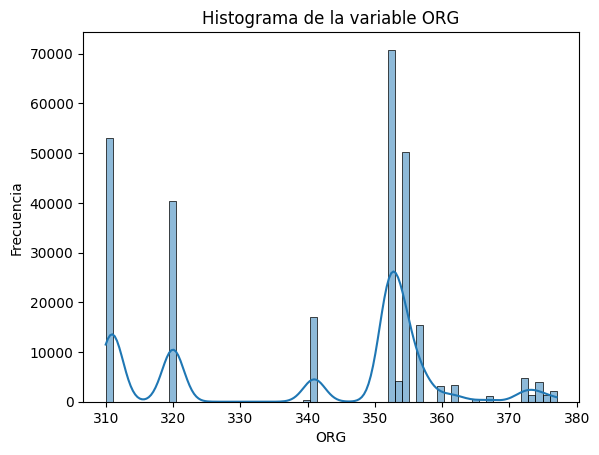

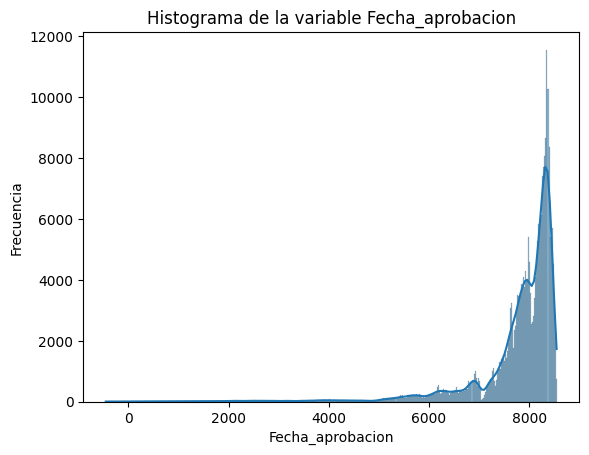

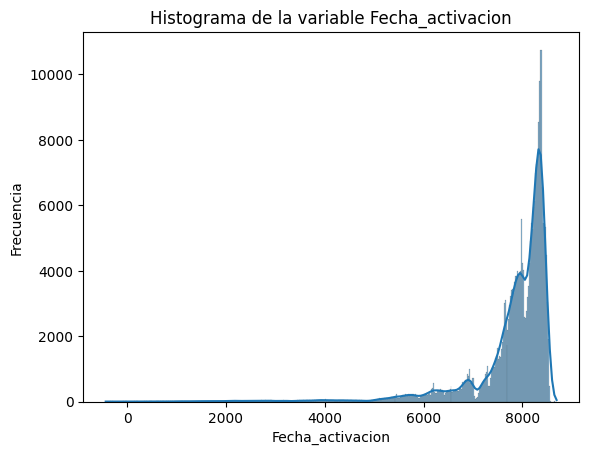

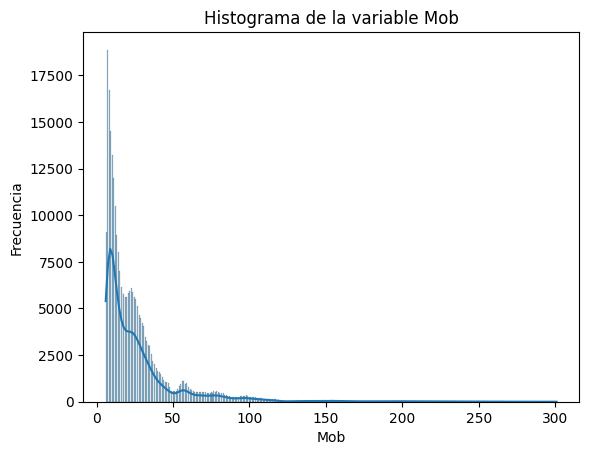

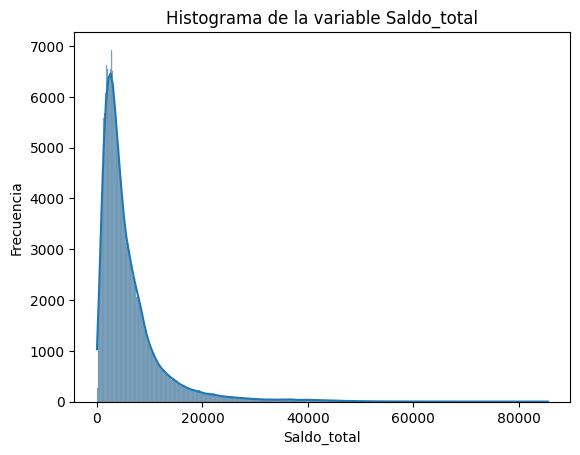

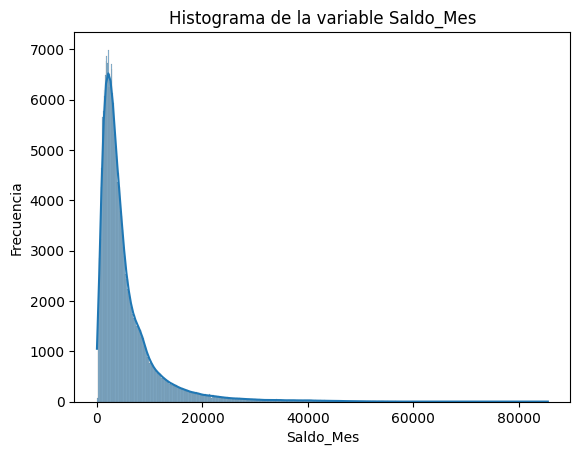

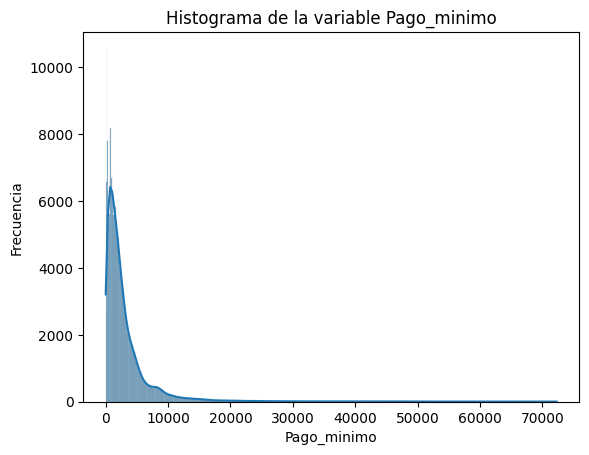

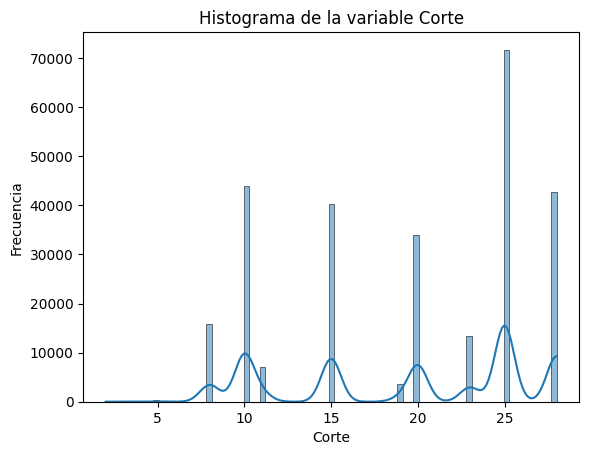

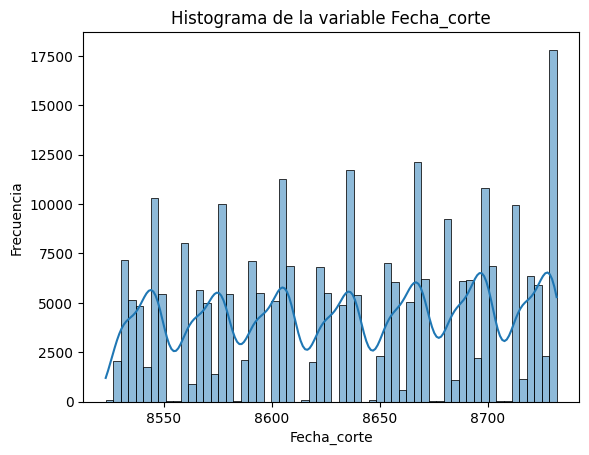

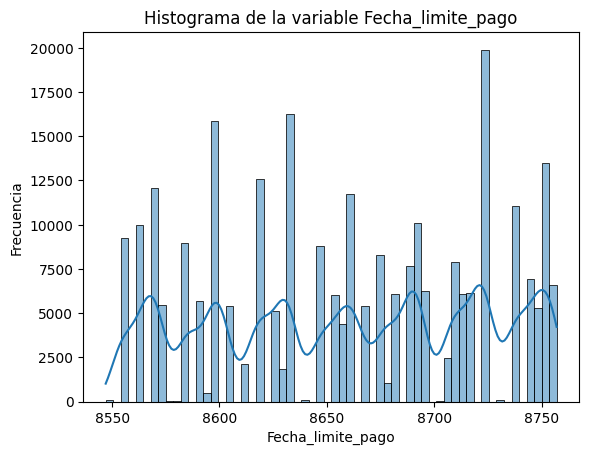

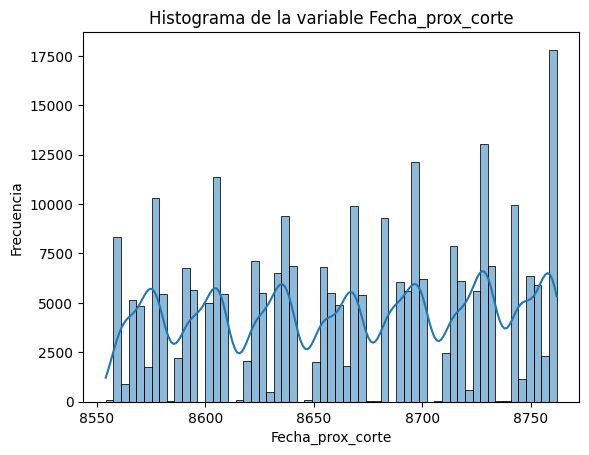

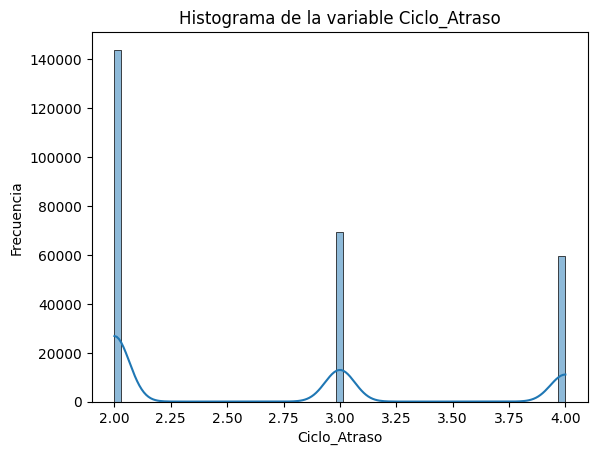

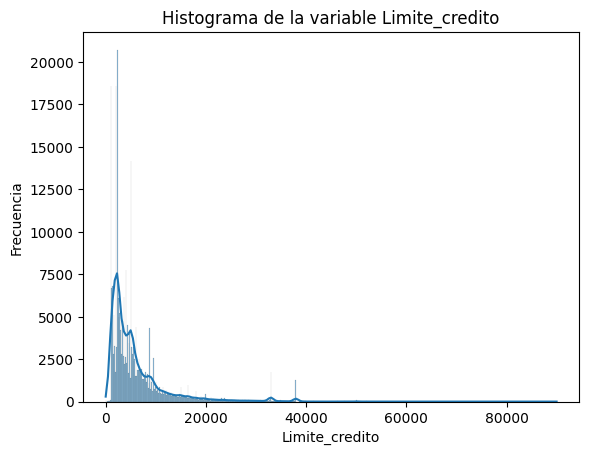

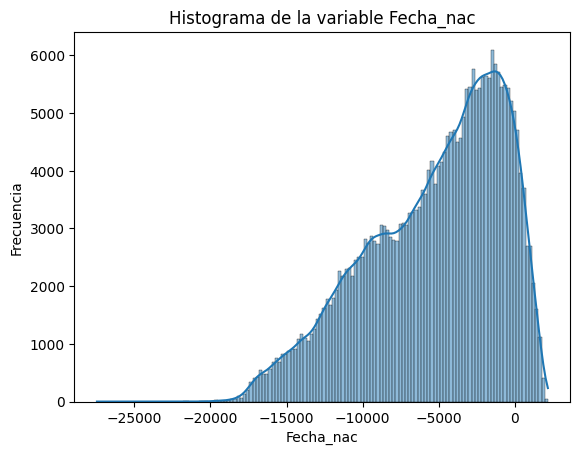

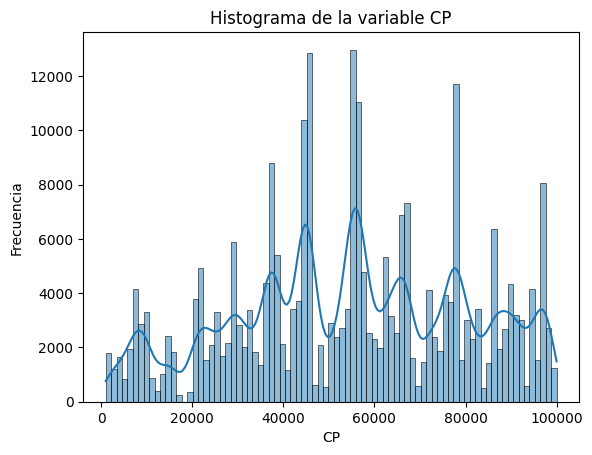

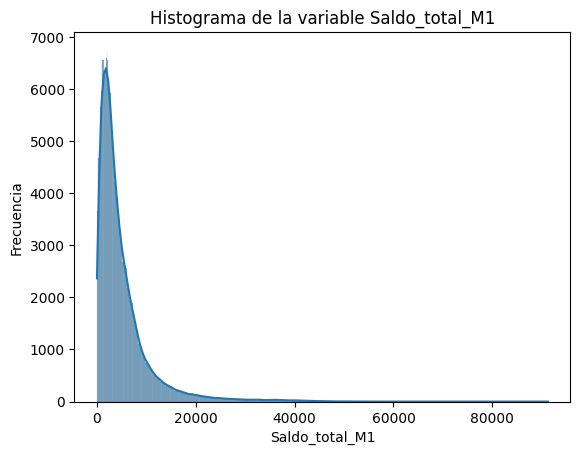

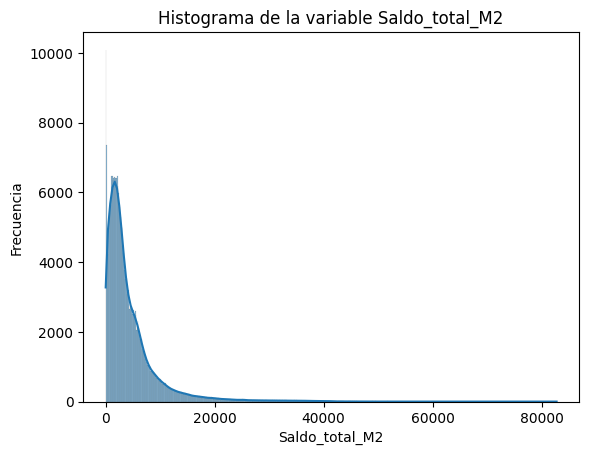

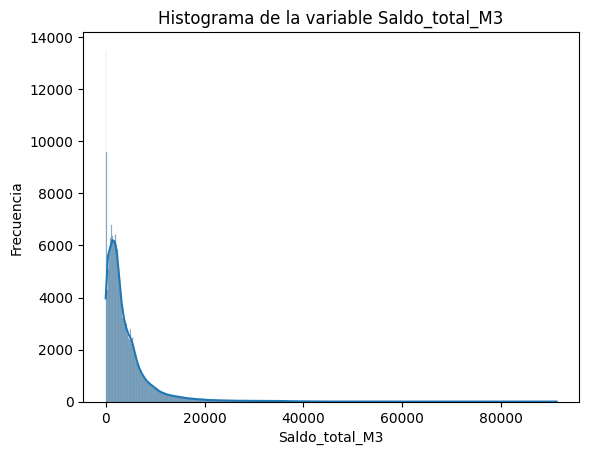

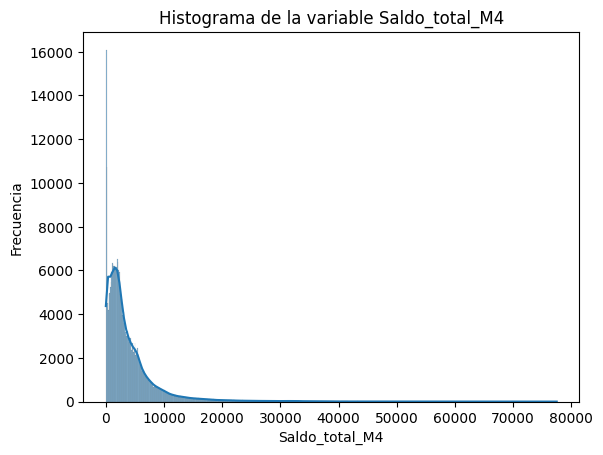

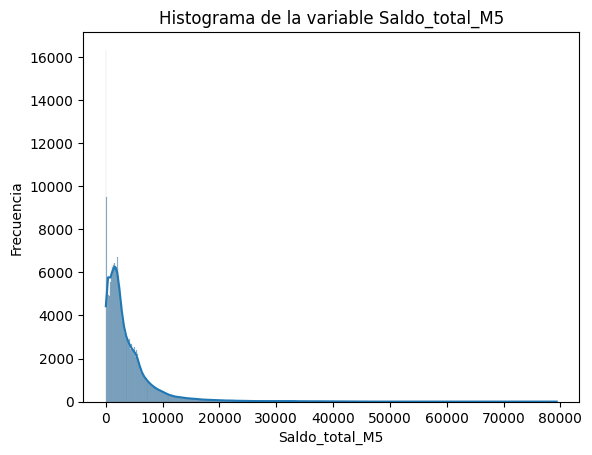

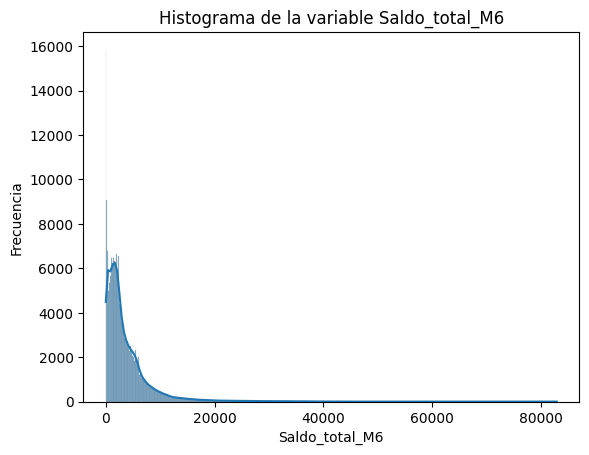

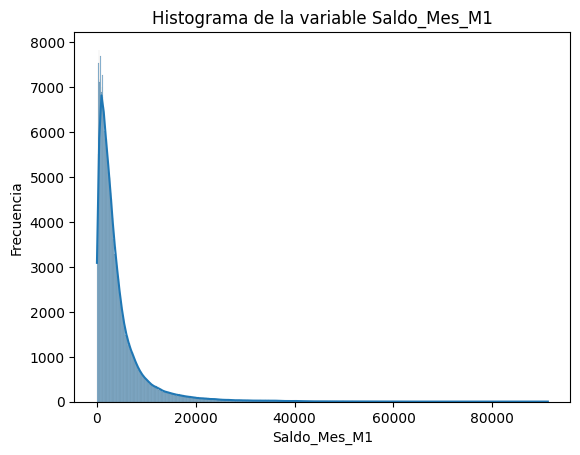

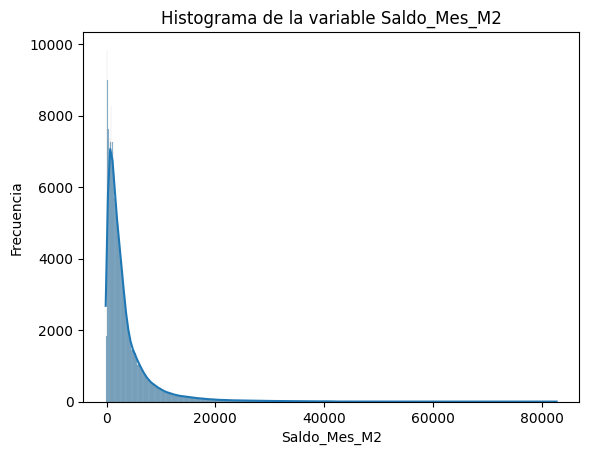

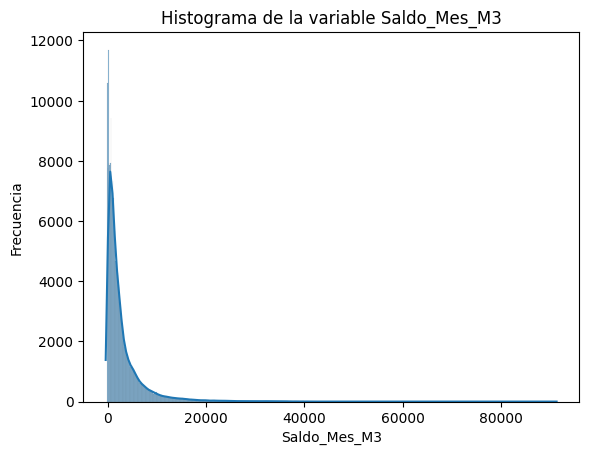

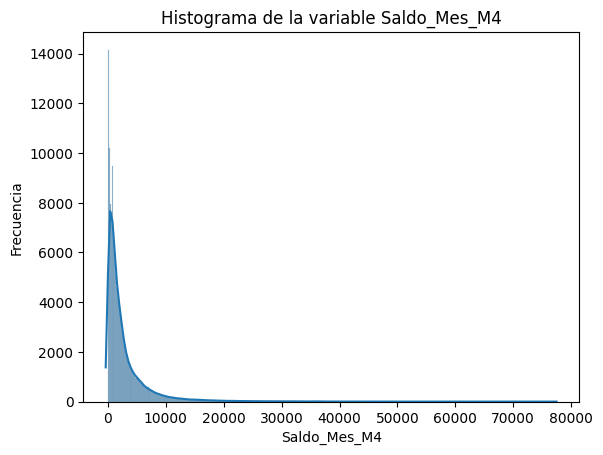

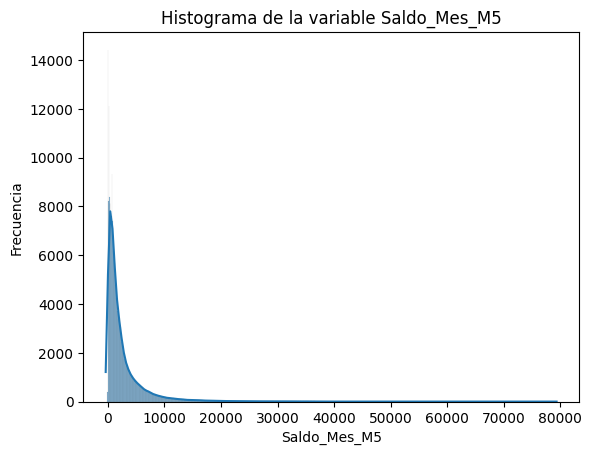

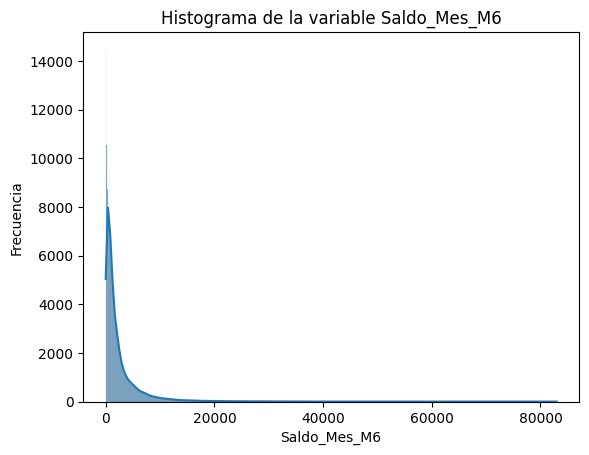

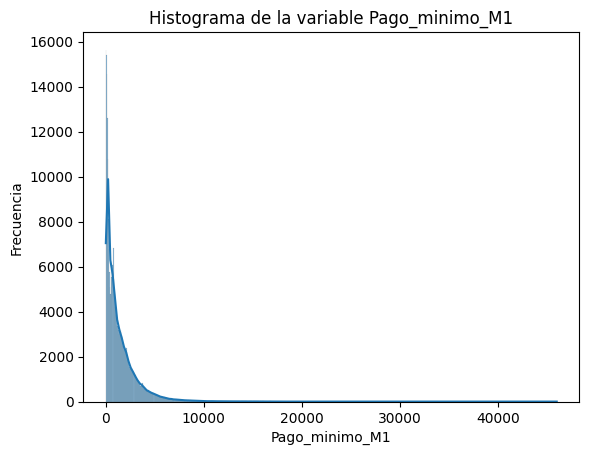

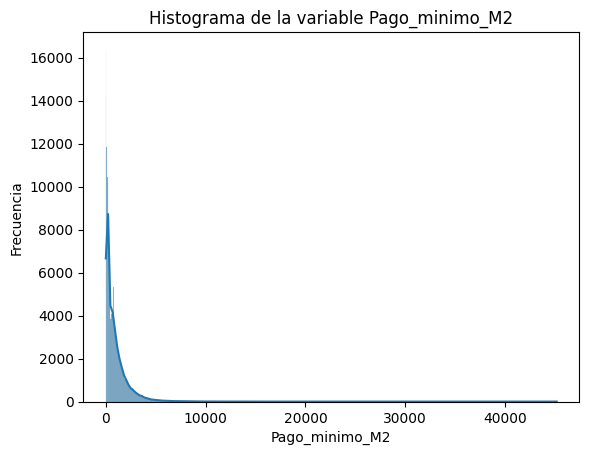

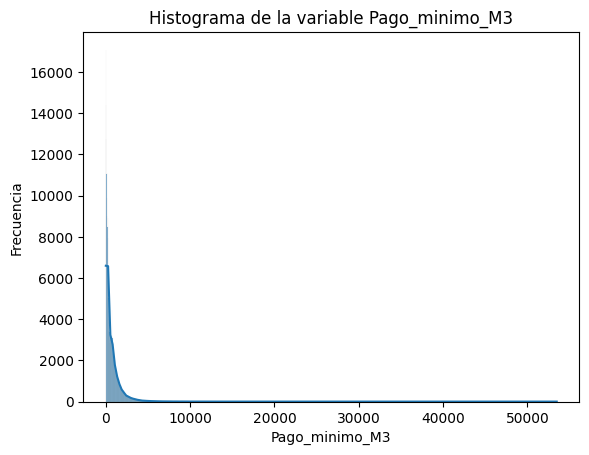

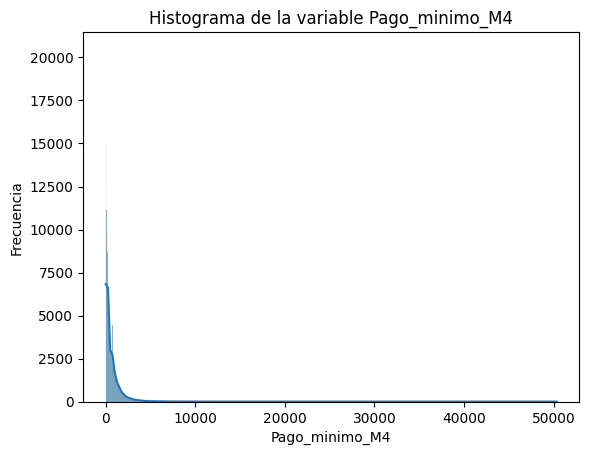

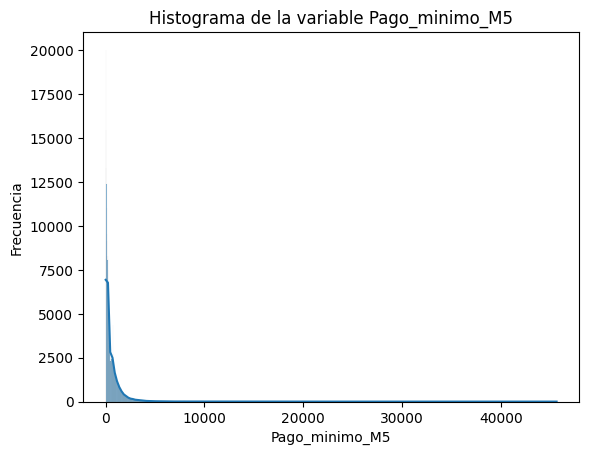

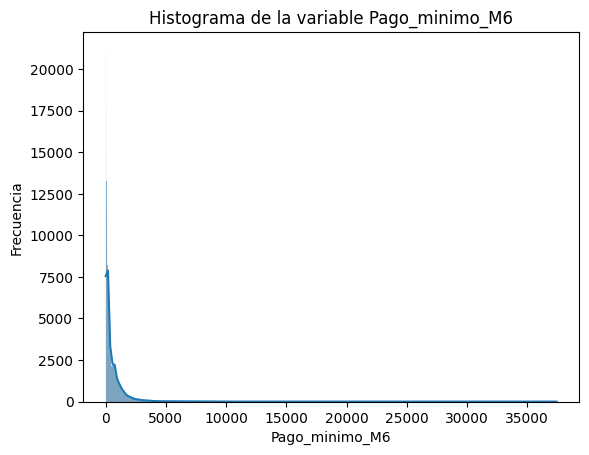

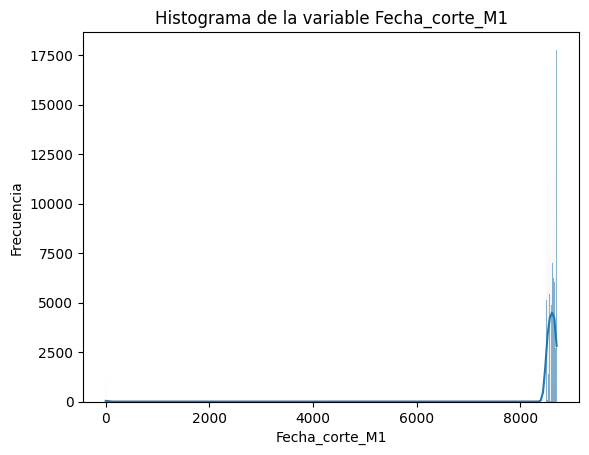

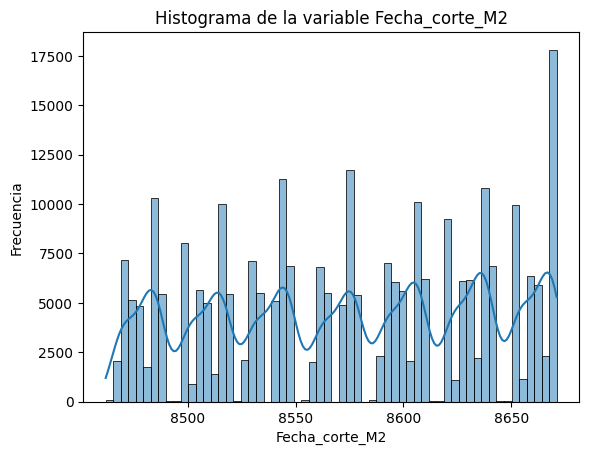

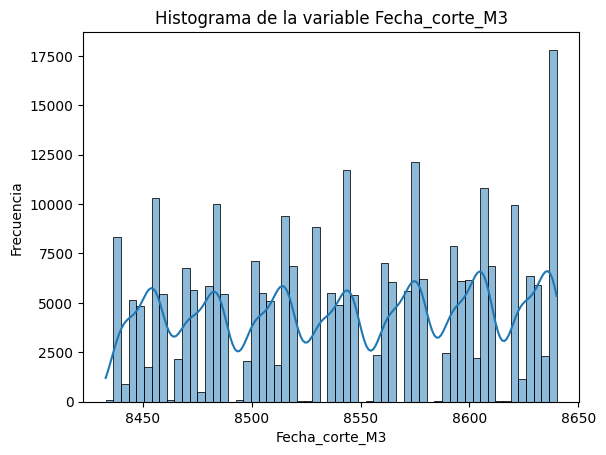

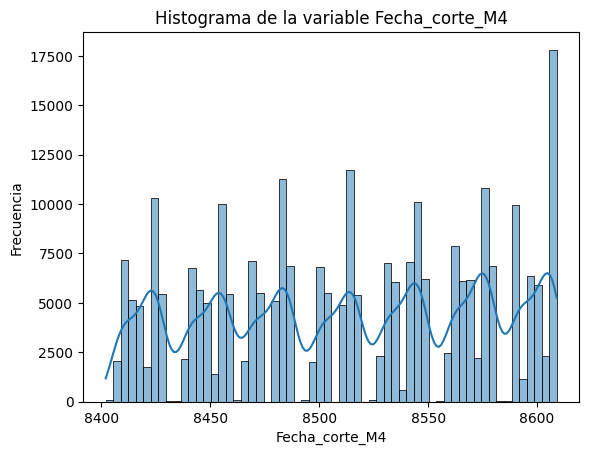

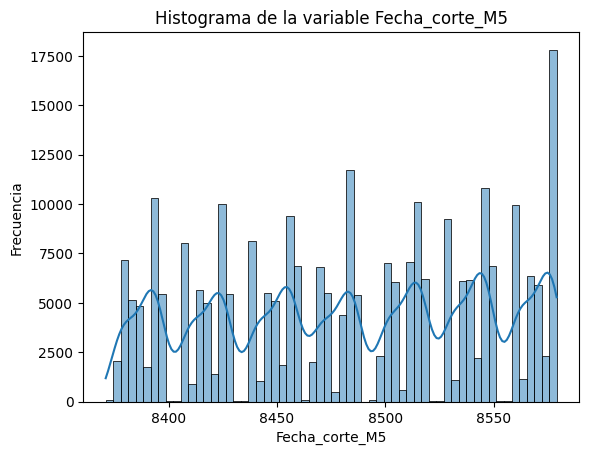

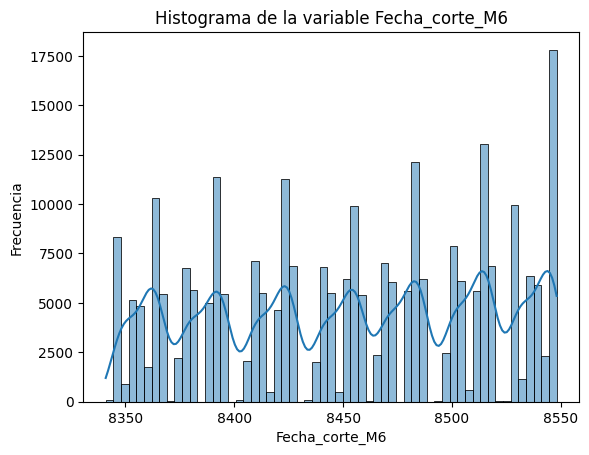

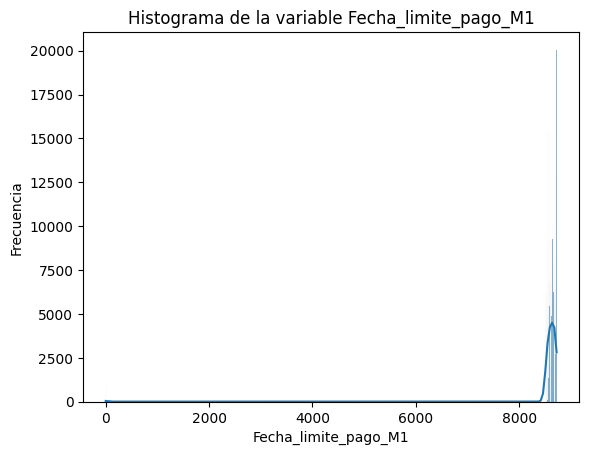

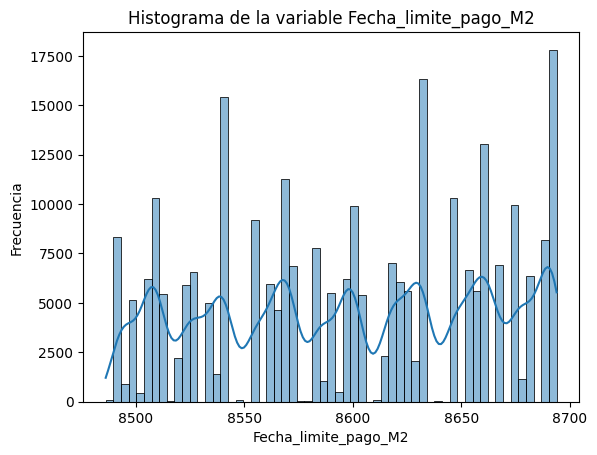

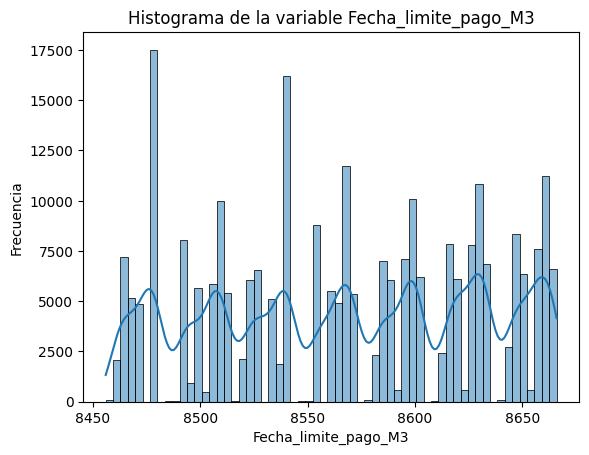

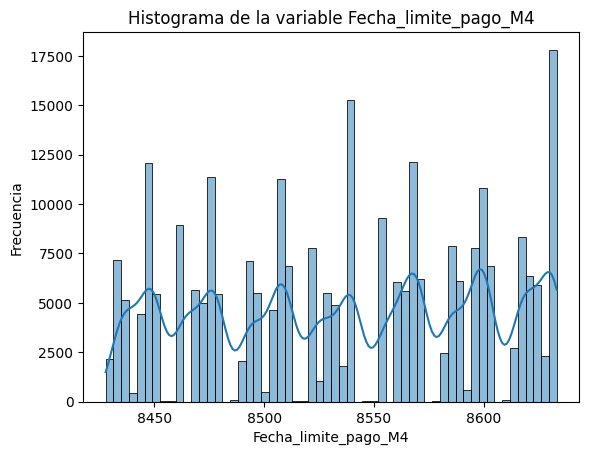

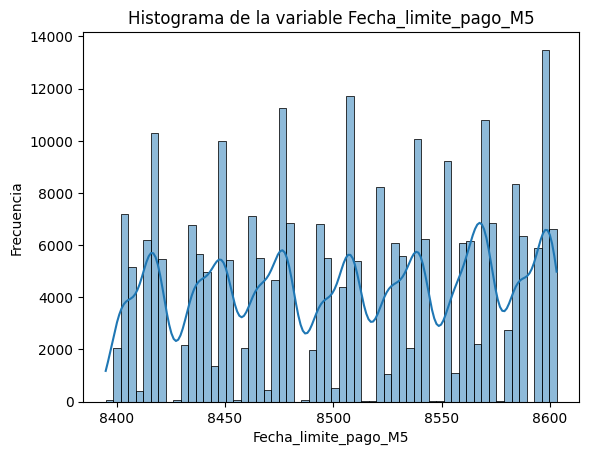

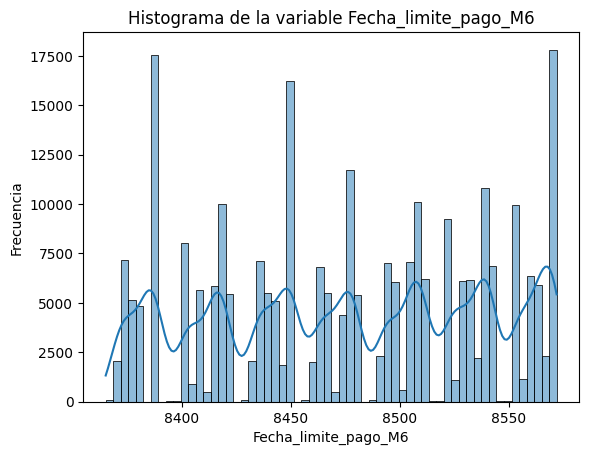

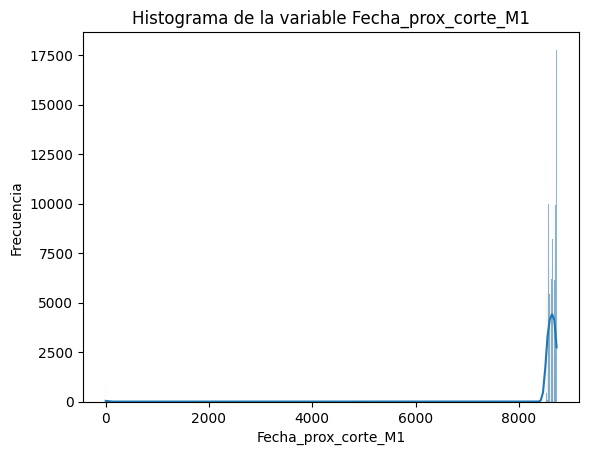

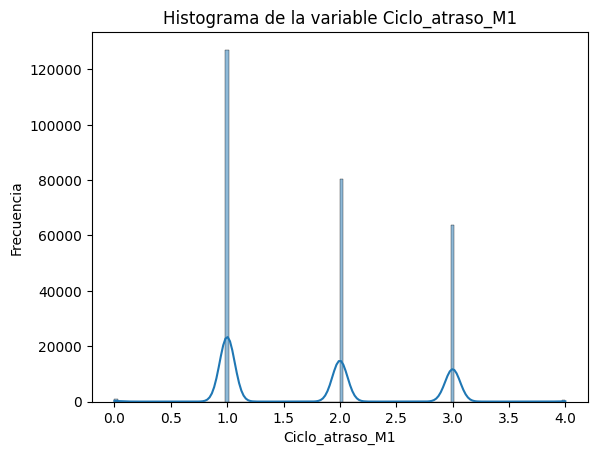

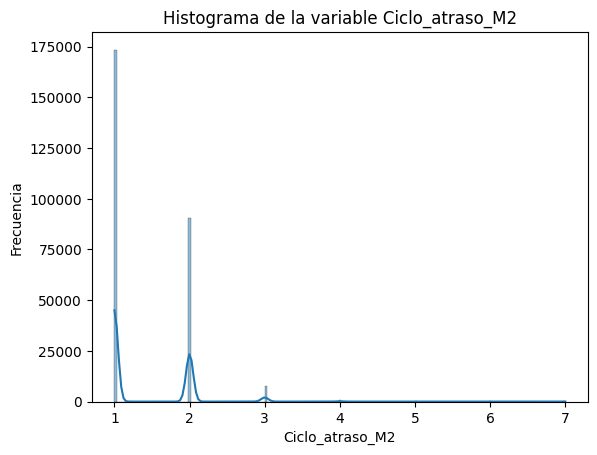

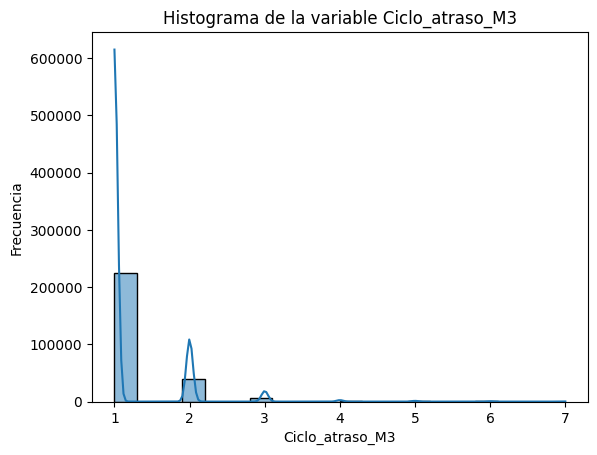

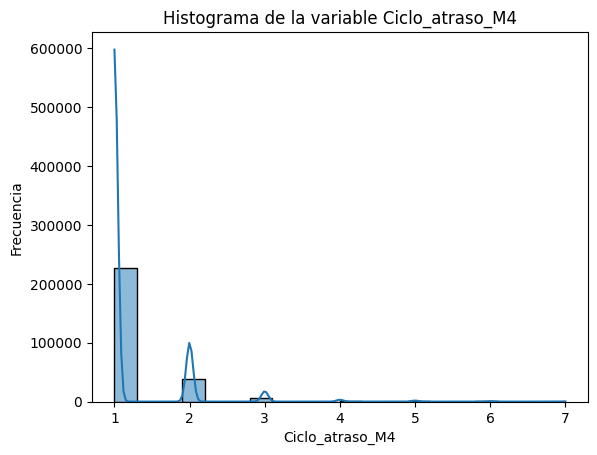

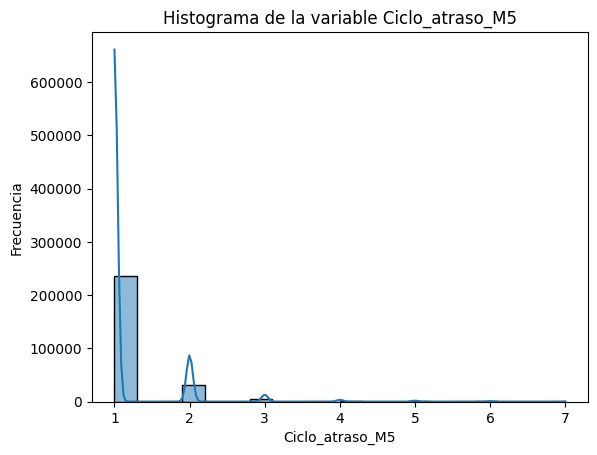

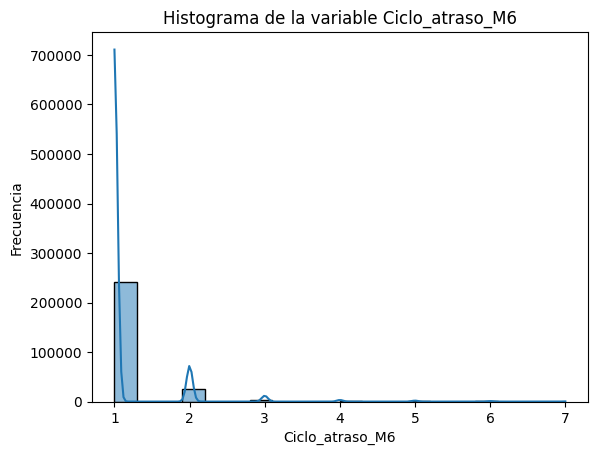

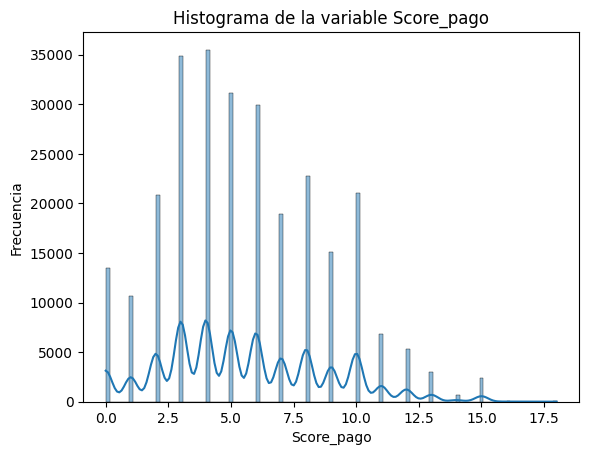

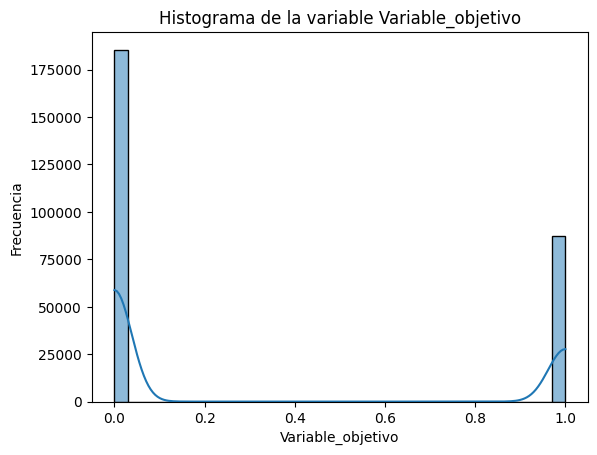

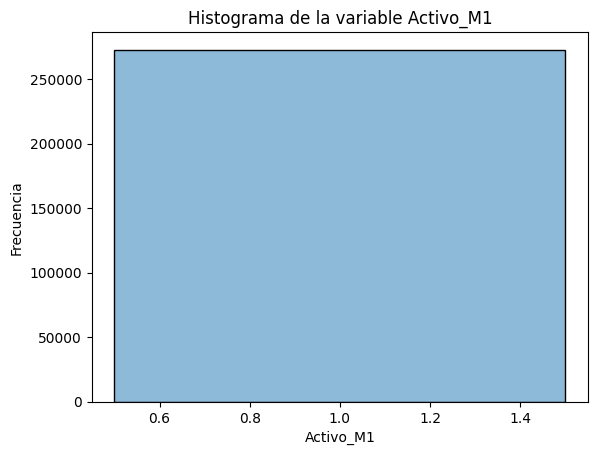

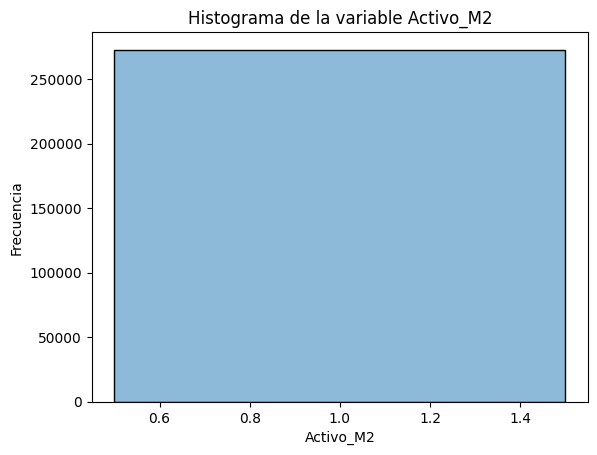

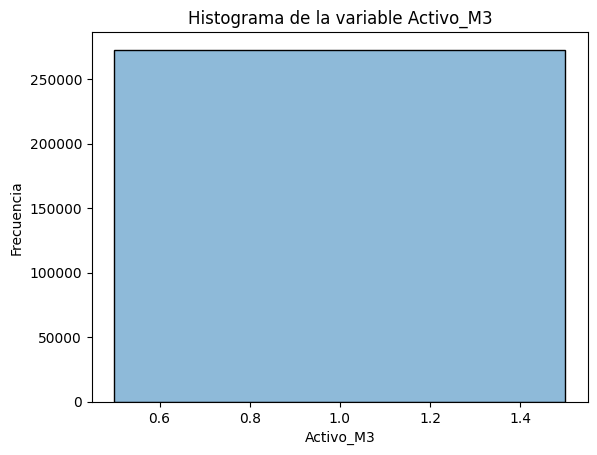

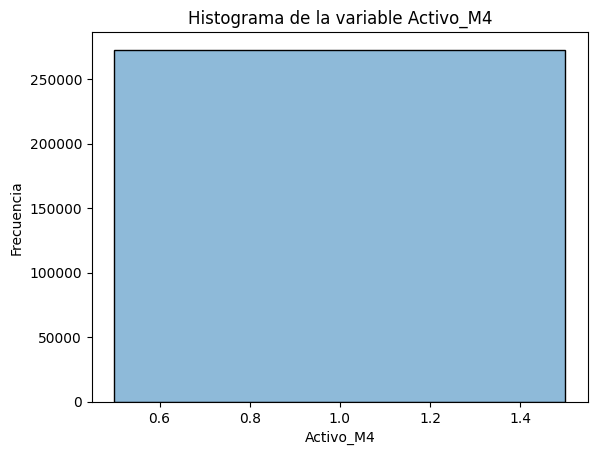

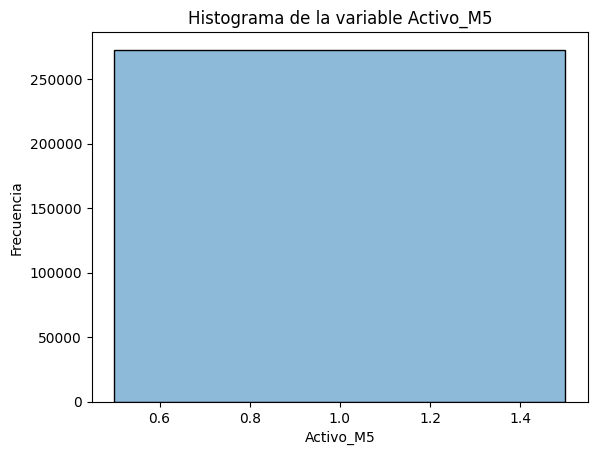

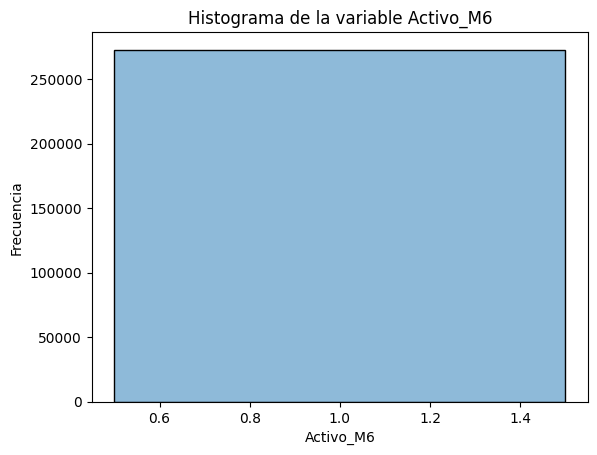

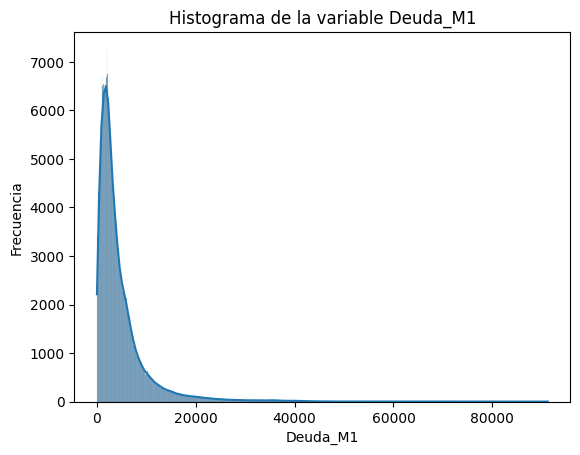

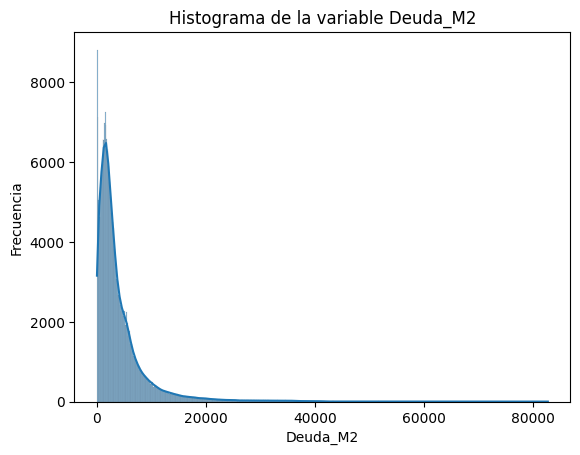

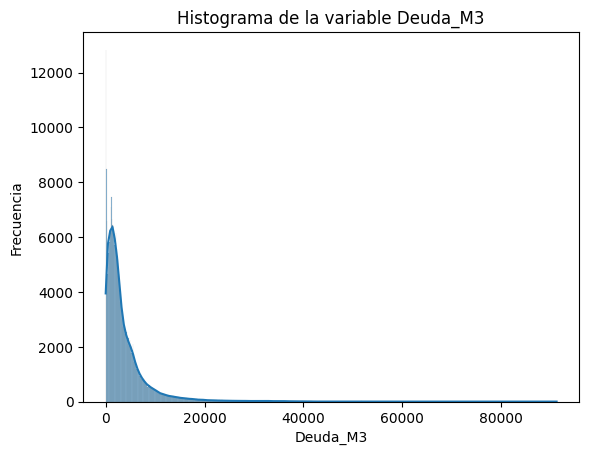

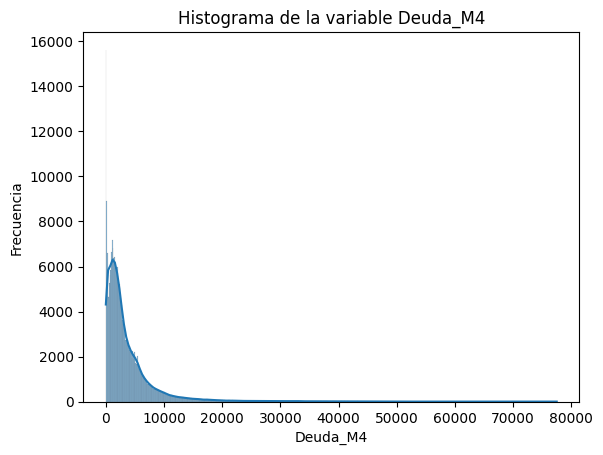

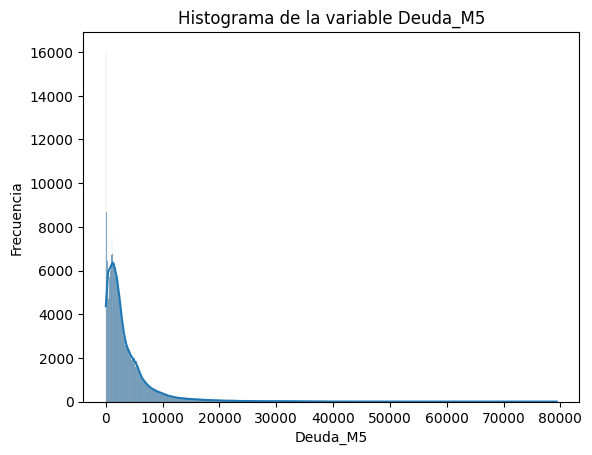

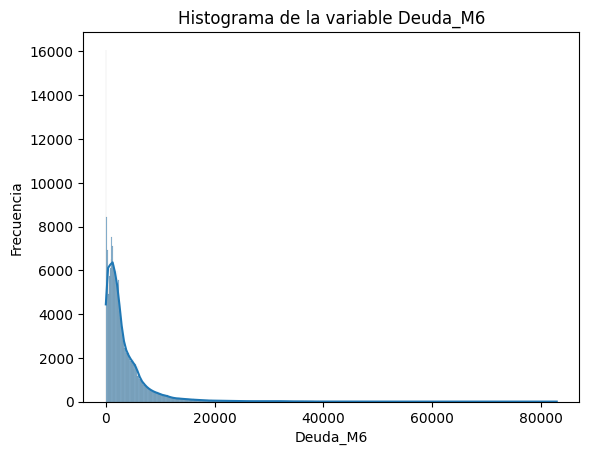

In [237]:
for col in df_numeric.columns:
    if col.startswith('Utilizacion'):
        continue
    sns.histplot(df_numeric[col], kde=True)
    plt.title(f'Histograma de la variable {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

### Box plots of numerical variables

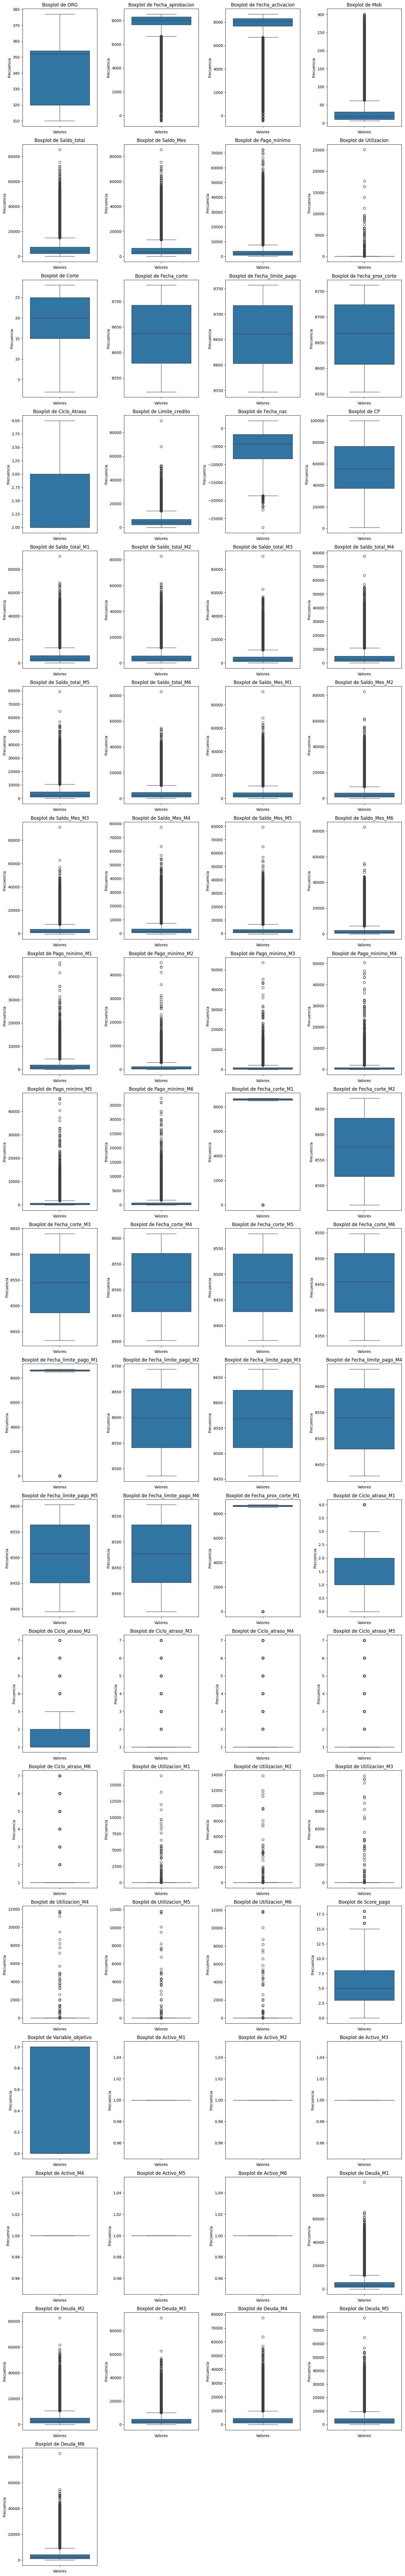

In [238]:
numerical_columns = df_numeric.columns
num_vars = len(numerical_columns)

ncols = 4 
nrows = int(np.ceil(num_vars / ncols))
plt.figure(figsize=(15, 5 * nrows))

for i, column in enumerate(numerical_columns):
    plt.subplot(nrows, ncols, i + 1)
    sns.boxplot(data=df_numeric[column])
    plt.title(f'Boxplot de {column}')
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


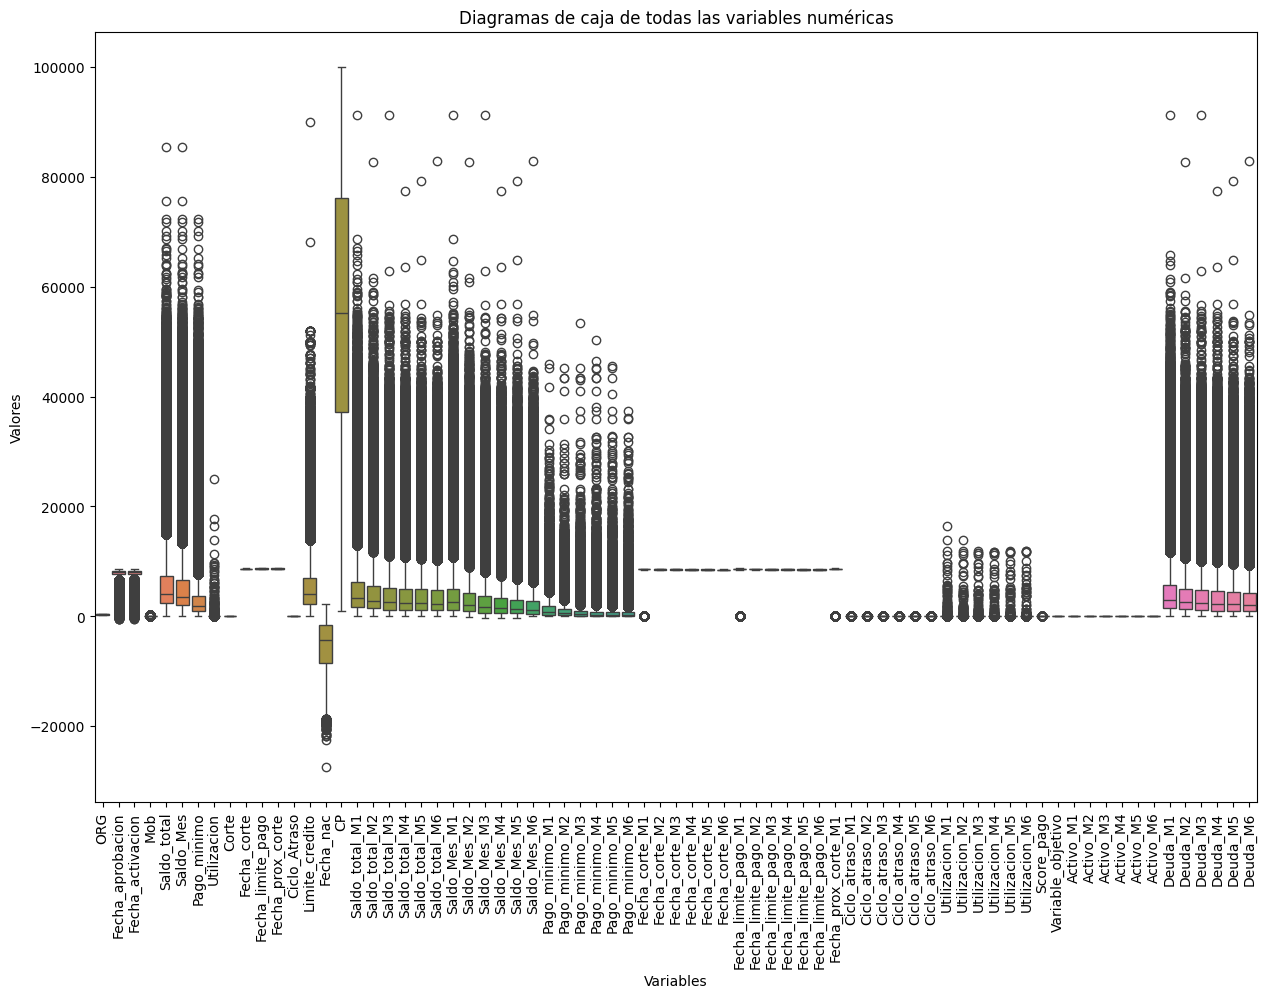

In [239]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_numeric)
plt.title('Diagramas de caja de todas las variables numéricas')
plt.xlabel('Variables')
plt.ylabel('Valores')
plt.xticks(rotation=90)
plt.show()

### Bar charts of categorical variables

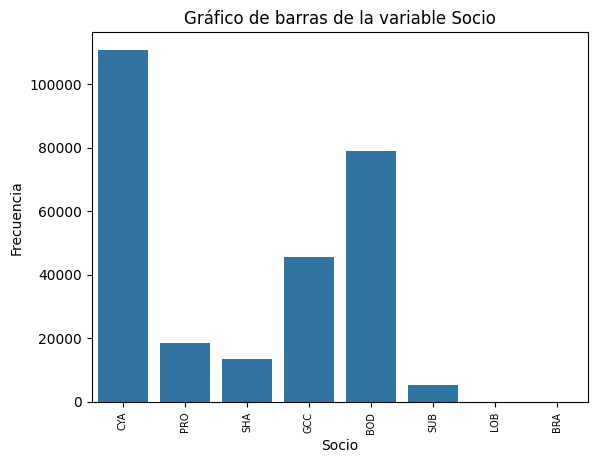

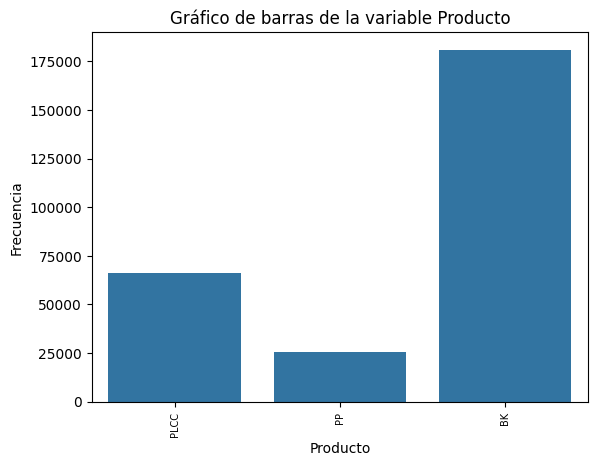

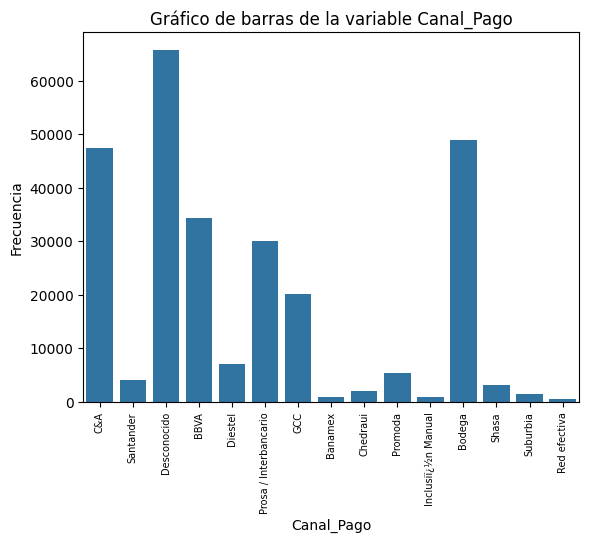

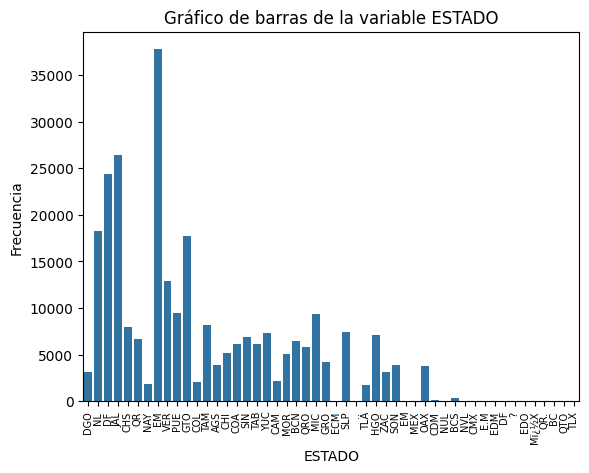

In [240]:
df_categorical = df_copy_sin_nan.select_dtypes(include=['object'])
for _ in df_categorical.columns:
    sns.countplot(x=_, data=df_categorical)
    plt.title(f'Gráfico de barras de la variable {_}')
    plt.xlabel(_)
    plt.xticks(rotation=90)
    plt.xticks(size=7)
    plt.ylabel('Frecuencia')
    plt.show()

### Export csv with dates converted to days

In [241]:
# Guardar el dataset procesado
df_copy_sin_nan.to_csv("COLL_TEC_CONSOLIDADO_Quasimerito_2.0_Final_FechasIguales.csv", index=False)

# Pre-processing

## Converting categorical variables with OneHotEncoder

In [245]:
def a_numericas(X):
    categorical_cols = df_categorical.columns

    # Codificación One-Hot para columnas categóricas
    if len(categorical_cols) > 0:
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        encoded_nominal = encoder.fit_transform(X[categorical_cols])
        encoded_nominal_df = pd.DataFrame(encoded_nominal, columns=encoder.get_feature_names_out(categorical_cols))
        X = X.drop(columns=categorical_cols).reset_index(drop=True)
        X = pd.concat([X, encoded_nominal_df], axis=1)

    return X

df_encoded = a_numericas(df_copy_sin_nan)
df_encoded.head()

,ORG,Fecha_aprobacion,Fecha_activacion,Mob,Saldo_total,Saldo_Mes,Pago_minimo,Utilizacion,Corte,Fecha_corte,...,ESTADO_SIN,ESTADO_SLP,ESTADO_SON,ESTADO_TAB,ESTADO_TAM,ESTADO_TLA,ESTADO_TLX,ESTADO_VER,ESTADO_YUC,ESTADO_ZAC
0,310,2494,2537,199,1533.90,734.40,115.0,0.174307,20,8540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,310,2725,2726,191,913.02,747.02,194.0,0.332007,20,8540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,310,2751,2751,190,5703.77,3942.12,553.0,0.769740,15,8535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,310,2621,2622,194,2653.88,2653.88,298.0,0.288465,10,8530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,310,2653,2654,193,3466.46,1328.87,313.0,0.376789,3,8523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Export clean encoded database

In [246]:
df_encoded.to_csv('df_encoded_2.0_FechasIguales.csv', index=False)

## Correlation of encoded variables with the target variable

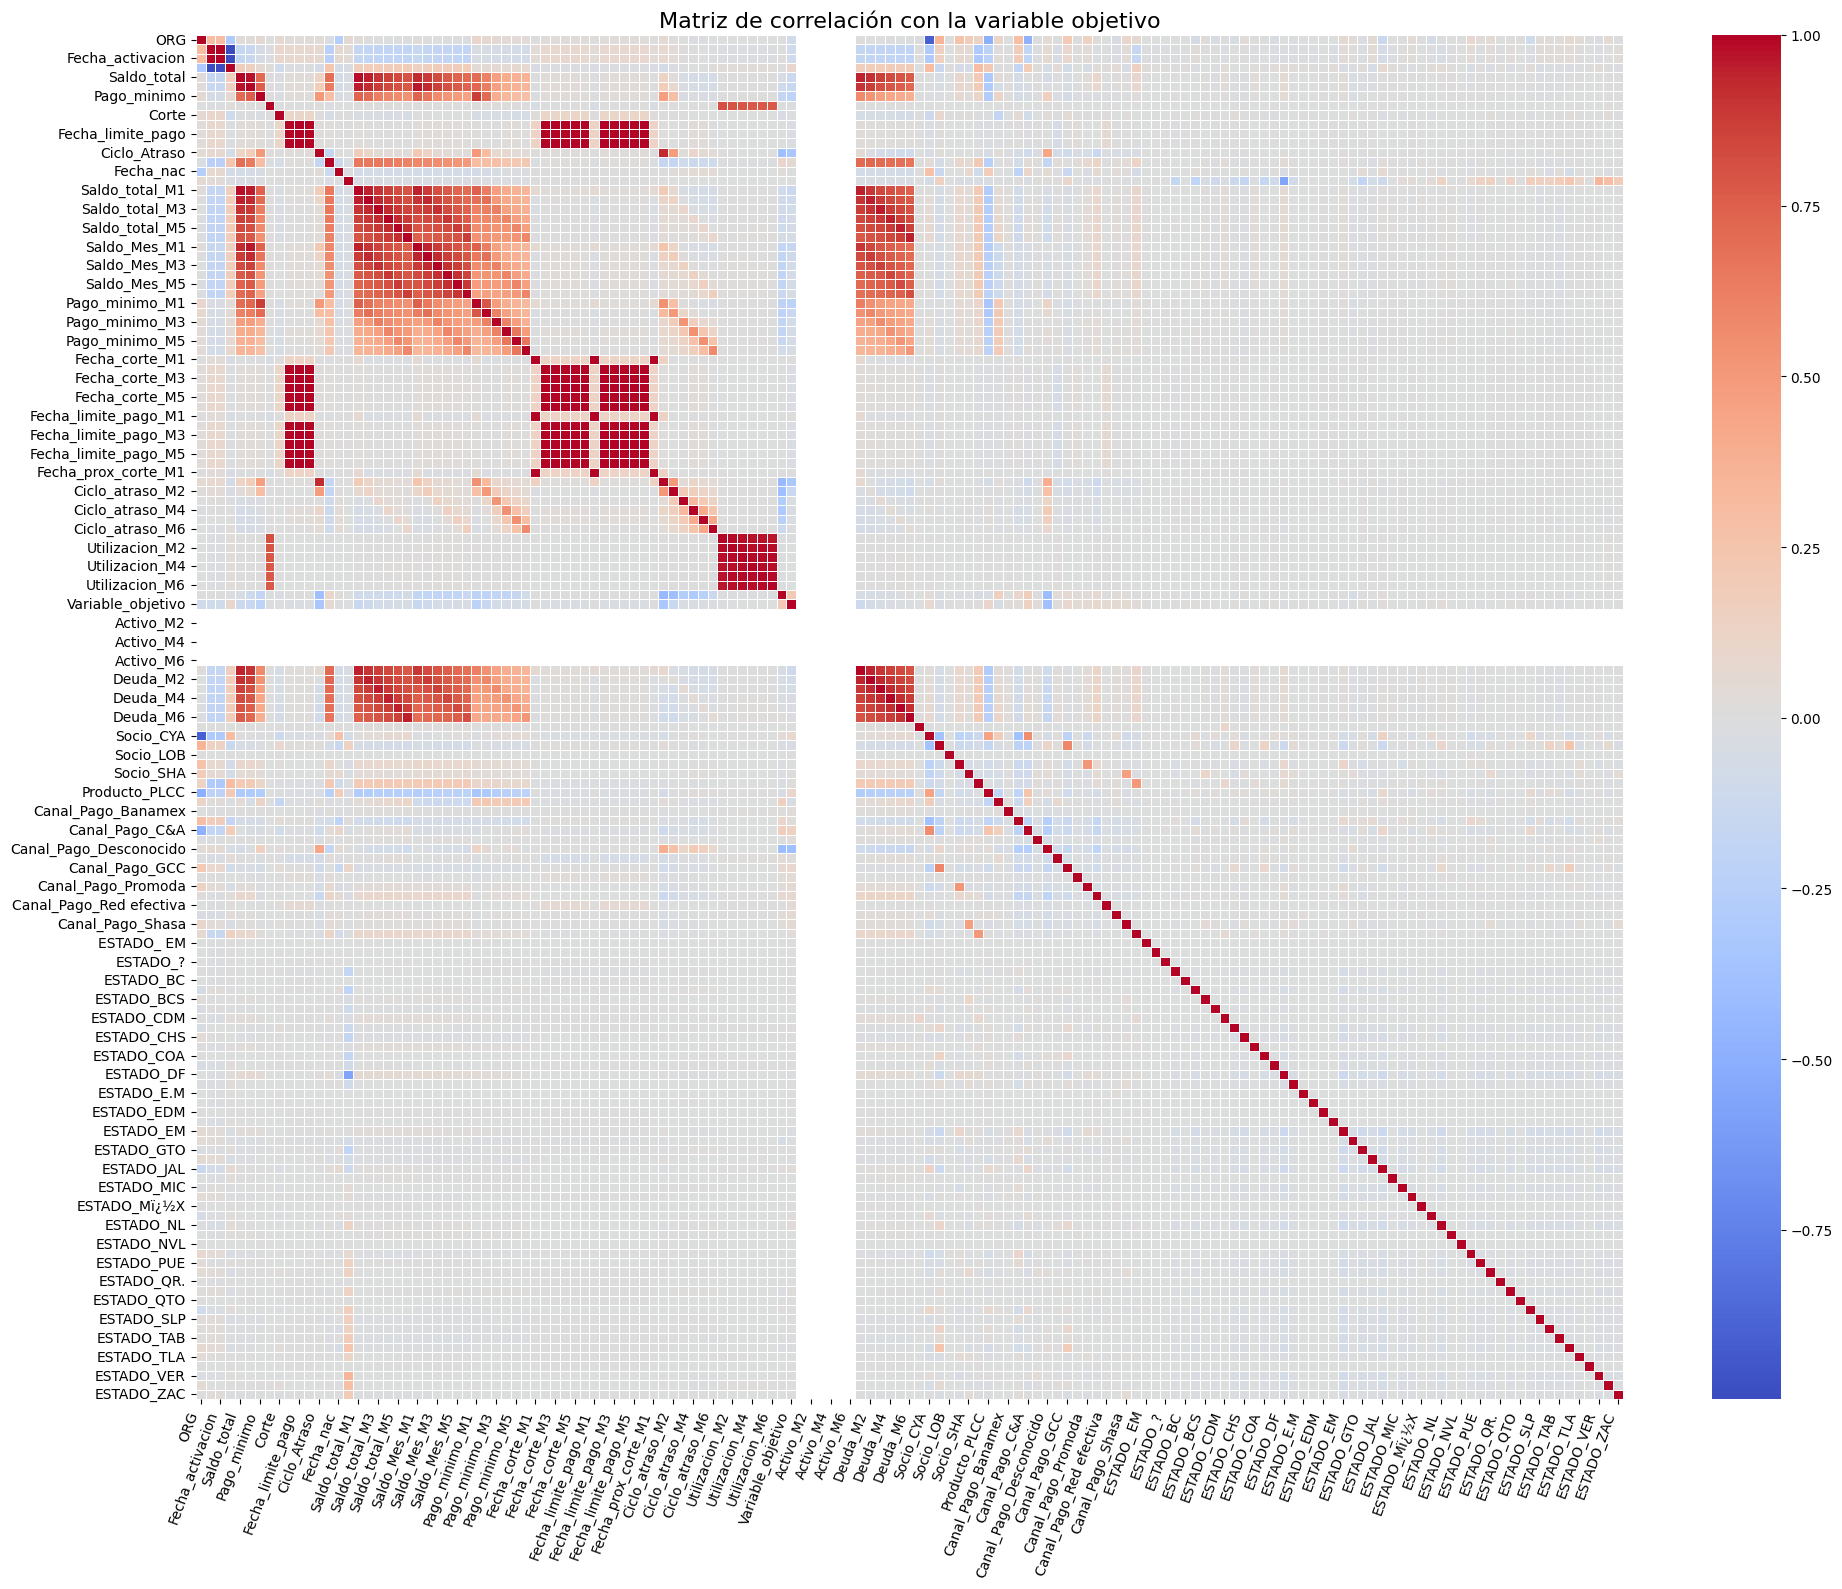

In [247]:
# Calcular la correlación de todas las variables numéricas con la variable objetivo
correlation_matrix = df_encoded.corr()

# Plotting the heatmap
plt.figure(figsize=(20, 16))  # Increase the size to fit all features
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5, annot_kws={"size": 10})

# Rotate x and y labels to prevent overlap
plt.xticks(rotation=70, ha='right')
plt.yticks(rotation=0, ha='right')

# Add title and adjust layout
plt.title(f'Matriz de correlación con la variable objetivo', fontsize=16)

#plt.title('Correlation Matrix for', fontsize=16)
plt.tight_layout()  # Ensure the plot fits into the figure area
plt.show()

correlation_target = correlation_matrix['Variable_objetivo'].drop('Variable_objetivo')


Top 20.0% variables correlacionadas: ['Canal_Pago_Desconocido', 'Ciclo_Atraso', 'Ciclo_atraso_M1', 'Pago_minimo_M1', 'Score_pago', 'Pago_minimo', 'Saldo_Mes_M1', 'Ciclo_atraso_M2', 'Canal_Pago_C&A', 'Pago_minimo_M2', 'Saldo_Mes', 'Saldo_total_M1', 'Saldo_total', 'Deuda_M1', 'Saldo_Mes_M2', 'Saldo_total_M2', 'Producto_PLCC', 'Fecha_activacion', 'Fecha_aprobacion', 'Mob', 'ORG', 'Canal_Pago_GCC', 'Canal_Pago_Prosa / Interbancario', 'Saldo_total_M3', 'Saldo_Mes_M3', 'Socio_CYA', 'Pago_minimo_M3', 'Deuda_M2']


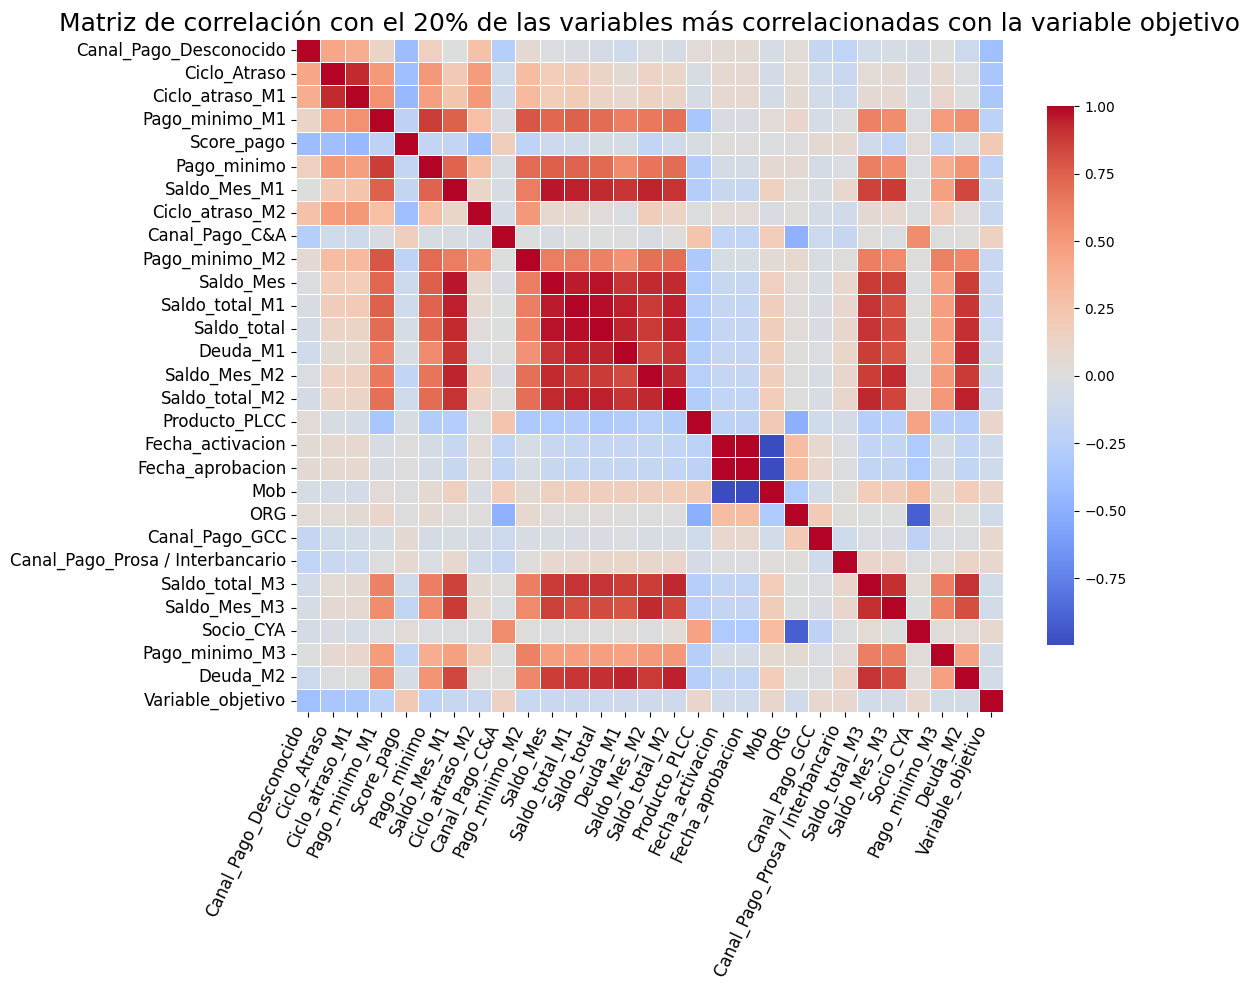

In [ ]:
# 30% más correlacionadas con target
def select_highest_corr_features(corr_with_target, percentage):
    num_features_to_select = int(len(corr_with_target) * percentage)
    if num_features_to_select == 0:
        num_features_to_select = 1
    selected_features = corr_with_target.abs().sort_values(ascending=False).head(num_features_to_select).index.tolist()
    print(f"Top {percentage*100}% variables correlacionadas: {selected_features}")
    return selected_features

top_features = select_highest_corr_features(correlation_target, percentage=0.2)

# Heatmap de las variables más correlacionadas con la variable objetivo
plt.figure(figsize=(12, 10)) 
sns.heatmap(df_encoded[top_features + ['Variable_objetivo']].corr(), 
            annot=False,
            cmap='coolwarm', 
            fmt='.2f', 
            cbar=True, 
            linewidths=0.5,
            cbar_kws={'shrink': 0.8})

plt.title(f'Matriz de correlación con el 20% de las variables más correlacionadas con la variable objetivo', fontsize=18)

plt.xticks(rotation=65, ha='right', fontsize=12)
plt.yticks(rotation=0, ha='right', fontsize=12)

plt.tight_layout() 
plt.show()


In [249]:
correlation_target = correlation_target.sort_values(ascending=False)
correlation_target

Score_pago        0.217058
Canal_Pago_C&A    0.144165
Producto_PLCC     0.101801
Mob               0.094090
Canal_Pago_GCC    0.083654
                    ...   
Activo_M2              NaN
Activo_M3              NaN
Activo_M4              NaN
Activo_M5              NaN
Activo_M6              NaN
Name: Variable_objetivo, Length: 144, dtype: float64

# Nota: no se porque no se calcula la correlación para las variables de activo